In [1]:
import MEArecTemplate as mr
import numpy as np
import matplotlib.pyplot as plt
import MEAutility as mu
import LFPy
from matplotlib.collections import LineCollection
from neuron import h
import os
import inspect
from pathlib import Path
import shutil
import plotly
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#%run ZIAD_MEArecDataFunctions.ipynb
%run ZIAD_MEARecHelperFunctions.ipynb

## Generate Templates

In [3]:
# Define which cell models to simulate (those in the folder that begin with 'L5')
# Define whether cells are excitatory ('exc') or inhibitory ('inh')

#mea_cells_folder = '/Users/Ziad/.config/mearec/1.7.2/cell_models/MEArecRecordingGeneration/'
mea_cells_folder = '/Users/Ziad/.config/mearec/1.7.2/cell_models/MEArecLinearCells/'
cell_models = []
cell_types = {}
for p in Path(mea_cells_folder).iterdir():
    if 'L5' in str(p):
        cell_models.append(p)
        cell_name = str(p).partition('MEArecLinearCells/')[-1]
        print(cell_name)
        cell_types[cell_name] = 'exc'

L5_DBC_bAC217_1
L5_MC_bAC217_1
L5_TTPC1_cADpyr232_1
L5_TTPC2_cADpyr232_1
L5_STPC_cADpyr232_1
L5_UTPC_cADpyr232_1


In [4]:
# Add custom probes to MEAutility
yaml_files = [f for f in os.listdir('.') if f.endswith('.yaml')]
print("Available Custom Probes: ", yaml_files)

Available Custom Probes:  ['1200000MEA1.yaml', '10201MEA30.yaml', '225MEA75.yaml', '100MEA100.yaml', '1000MEA1.yaml', '1000000MEA2.yaml', '2250000MEA2.yaml', '400MEA50.yaml', '4000000MEA2.yaml', '225MEA75.0.yaml', '250kMEA2.yaml', '400MEA[2, 10].yaml', '4MEA1000.yaml', '100MEA50.yaml', '40000MEA[1, 5].yaml', '1000MEA1_Axial.yaml', '800MEA[2, 10].yaml', '50MEA60_Axial.yaml', '10000MEA30.yaml', '100MEA100.0.yaml', '4000000MEA1.yaml', '225MEA50.yaml', '100MEA25.yaml', '10MEA1.yaml', 'testmea.yaml', '400MEA100.yaml', '100MEA75.yaml', '225MEA50.0.yaml', '100MEA60_Axial.yaml', '1500000MEA2.yaml', '50MEA60.yaml', '60MEA100.yaml', '225MEA100.0.yaml', '400MEA75.yaml', '100MEA1_Axial.yaml', '500MEA1.yaml']


In [5]:
# Add custom MEA probe if necessary
custom_probe = True
#mea_name = 'Ziad_Custom_-2_100MEA75'
#mea_name = '100MEA75'
#mea_name = 'Neuropixels-128'
mea_name = '10000MEA30'
neuropixel_noise = False
ylim = None
zlim = None
lim_factor = 0.85

template_params = mr.get_default_templates_params()

if 'Ziad_Custom' in mea_name:
    last_under_idx = mea_name.rindex('_')
    second_last_under_idx = mea_name[:last_under_idx].rindex('_')
    
    mea_temp_name = mea_name[last_under_idx+1:]
    mea_offset = int(mea_name[second_last_under_idx+1:last_under_idx])
    
    custom_mea = mu.return_mea(mea_temp_name)
    
    # Set limits to be smaller than area covered by array 
    ymin = np.min(custom_mea.positions[:, 1])
    ymax = np.max(custom_mea.positions[:, 1])
    zmin = np.min(custom_mea.positions[:, 2])
    zmax = np.max(custom_mea.positions[:, 2])

    ylim = [lim_factor*ymin, lim_factor*ymax]
    zlim = [lim_factor*zmin, lim_factor*zmax]
    print("ylim: ", ylim, ", zlim: ", zlim)
    
    pos = np.vstack((custom_mea.positions, custom_mea.positions + np.array([mea_offset, 0, 0])))
    mea_info = {'pos': pos, 'center':False, 'type':'mea'}
    template_params['probe_info'] = mea_info

elif ('Neuropixel' in mea_name) == False:
    #mea_name = '100MEA75'
    mu.add_mea(mea_name + '.yaml')
    custom_mea = mu.return_mea(mea_name)

    #    Set limits to be smaller than area covered by array 
    ymin = np.min(custom_mea.positions[:, 1])
    ymax = np.max(custom_mea.positions[:, 1])
    zmin = np.min(custom_mea.positions[:, 2])
    zmax = np.max(custom_mea.positions[:, 2])
    #print("Positions: ", custom_mea.positions)


    ylim = [lim_factor*ymin, lim_factor*ymax]
    zlim = [lim_factor*zmin, lim_factor*zmax]
    print("ylim: ", ylim, ", zlim: ", zlim)
    
else: # Limits for neuropixels array
    mea = mu.return_mea(mea_name)
    ymin = np.min(mea.positions[:, 1])
    ymax = np.max(mea.positions[:, 1])
    zmin = np.min(mea.positions[:, 2])
    zmax = np.max(mea.positions[:, 2])
    # First ylim was *1.5, second should be *2.5
    ylim = [ymin*1.5, ymax*1.5]
    template_params['npixel_radius'] = 25.0
    
    if neuropixel_noise == True:
        template_params['npixel_radius_noise'] = [100, 200]
    
    zlim = [lim_factor*zmin, lim_factor*zmax]
    print("ylim: ", ylim, ", zlim: ", zlim)

# Initialize parameters for template generation

template_params['n'] = 1 # Number of random positions the cell is simulated in
#template_params['probe'] = 'SqMEA-7-20' # Electrode array configuration (7x7 with 20um pitch)
template_params['probe'] = mea_name
template_params['xlim'] = [10, 20]
template_params['ylim'] = ylim
template_params['zlim'] = zlim
template_params['ncontacts'] = 1
template_params['neuropixels'] = 'Neuropixels' in mea_name
template_params['deactivate'] = 'None'

for param in template_params:
    print(param, "=", template_params[param])

['1000000MEA2', '10000MEA30', '1000MEA1', '1000MEA1_Axial', '100MEA100', '100MEA1_Axial', '100MEA25', '100MEA50', '100MEA60_Axial', '100MEA75', '10201MEA30', '10MEA1', '1200000MEA1', '1500000MEA2', '2250000MEA2', '225MEA75', '250kMEA2', '4000000MEA1', '4000000MEA2', '40000MEA[1, 5]', '400MEA100', '400MEA50', '400MEA75', '400MEA[2, 10]', '4MEA1000', '500MEA1', '50MEA60', '50MEA60_Axial', '800MEA[2, 10]', 'Neuronexus-32', 'Neuropixels-128', 'Neuropixels-24', 'Neuropixels-384', 'Neuropixels-64', 'Neuroseeker-128', 'SqMEA-10-15', 'SqMEA-15-10', 'SqMEA-5-30', 'SqMEA-6-25', 'SqMEA-7-20', 'monotrode', 'testmea', 'tetrode', 'tetrode-mea-d', 'tetrode-mea-l', 'tetrode-mea-s']
ylim:  [-1262.25, 1262.25] , zlim:  [-1262.25, 1262.25]
sim_time = 1
target_spikes = [3, 50]
cut_out = [2, 5]
dt = 0.03125
delay = 10
weights = [0.25, 1.75]
rot = physrot
probe = 10000MEA30
ncontacts = 1
overhang = 30
offset = 0
xlim = [10, 20]
ylim = [-1262.25, 1262.25]
zlim = [-1262.25, 1262.25]
min_amp = 30
n = 1
seed = 

## Generate Locations and Rotations

In [24]:
#cell_temps = ['L5_TTPC1_cADpyr232_1', 'L5_TTPC2_cADpyr232_1']
#cell_temps = ['L5_TTPC1_cADpyr232_1']
cell_temps = ['L5_MC_bAC217_1']

#cell_temps = ['L5_UTPC_cADpyr232_1']
#cell_temps = ['L5_DBC_bAC217_1', 'L5_MC_bAC217_1']
#cell_temps = ['L5_STPC_cADpyr232_1', 'L5_UTPC_cADpyr232_1']
# cell_temps = ['L5_DBC_bAC217_1',
#               'L5_MC_bAC217_1',
#               'L5_TTPC1_cADpyr232_1',
#               'L5_TTPC2_cADpyr232_1',
#               'L5_STPC_cADpyr232_1',
#               'L5_UTPC_cADpyr232_1']

# Generate locations and rotations
num_cells = len(cell_temps)*template_params['n']
cell_locations = np.zeros((num_cells, 3))
cell_rotations = np.zeros((num_cells, 3))

# Limit cell positions and rotations to mimic neuropixel placement to test whether correlation is lower
# Neuropixels: Limit rotation to +/- 10 degrees
#zlim = [-70, 70]
if 'Neuropixels' in mea_name:
    rot_lim_degrees = 10.0
else:
    rot_lim_degrees = 360.0
rot_lim = rot_lim_degrees/360.0*2*np.pi

#np.random.seed(1)
xlim = template_params['xlim']
for i in range(len(cell_temps)):
    for j in range(template_params['n']):
        index = i*template_params['n'] + j
        cell_locations[index][0] = np.random.random()*(xlim[1]-xlim[0]) + xlim[0]
        cell_locations[index][1] = np.random.random()*(ylim[1]-ylim[0]) + ylim[0]
        cell_locations[index][2] = np.random.random()*(zlim[1]-zlim[0]) + zlim[0]
        cell_rotations[index][0] = np.random.random()*rot_lim
        if 'Neuropixels' in mea_name:
            
            phi = np.random.random() * np.pi
            r = np.sqrt(np.random.random()) * template_params['npixel_radius']

            # transform
            x = r * np.cos(phi)
            y = r * np.sin(phi)
            cell_locations[index][0] = y + xlim[0]
            cell_locations[index][1] = x
            
            if neuropixel_noise == True:
                phi = np.random.random() * np.pi
                radius_min = template_params['npixel_radius_noise'][0]
                radius_max = template_params['npixel_radius_noise'][1] - template_params['npixel_radius_noise'][0]
                r = np.sqrt(np.random.random()) * radius_max + radius_min
                
                x = r * np.cos(phi)
                y = r * np.sin(phi)
                cell_locations[index][0] = y + xlim[0]
                cell_locations[index][1] = x
                
#                 cell_locations[index][0] = np.random.random()*(noise_xlim[1]-noise_xlim[0]) + noise_xlim[0]
#                 cell_locations[index][1] = np.random.random()*(noise_ylim[1]-noise_ylim[0]) + noise_ylim[0]
#                 if np.random.random() >= 0.5:
#                     cell_locations[index][1] *= -1
                
            cell_rotations[index][0] = (np.random.random()*2 - 1)*rot_lim + np.pi/2
            if np.random.random() >= 0.5:
                cell_rotations[index][0] *= -1
            #cell_rotations[index][1] = (10.0 + np.random.random()*15)/180
            cell_rotations[index][1] = (np.random.random()*20)/180
            if cell_rotations[index][0] < 0:
                cell_rotations[index][1] *= -1
            cell_rotations[index][2] = np.random.random()*2*np.pi

In [25]:
print(cell_rotations)
print(cell_locations)

[[3.79278165 0.         0.        ]]
[[  10.88368618  701.33020083 -137.87225802]]


In [26]:
# cell_locations[0] = [15, 0, 0]
# cell_locations[1] = [15, 50, -50]
# cell_locations[2] = [15, 50, 100]

# cell_rotations[0] = [np.pi/2, 0, 0]
# cell_rotations[1] = [np.pi/2, 0, 0]
# cell_rotations[2] = [np.pi/2 + np.pi/3, 0, 0]

# cell_locations[0] = [15, 0, 0]
# cell_rotations[0] = [0, 0, 0]

cell_locations[0] = [15, 0, 0]
cell_rotations[0] = [np.pi/2, 0, 0]

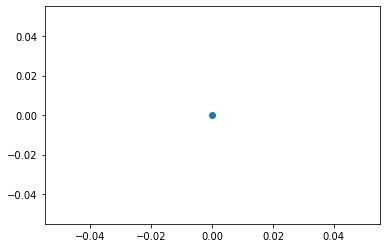

In [27]:
if 'Neuropixels' in mea_name:
    plt.scatter(cell_locations[:, 0], cell_locations[:, 1])
else:
    plt.scatter(cell_locations[:, 1], cell_locations[:, 2])

In [28]:
# # Translation code
# zstep = zlim[1]/(len(cell_temps)*template_params['n'])
# print(zstep)

# for i in range(len(cell_temps)):
#     for j in range(template_params['n']):
#         index = i*template_params['n'] + j
#         cell_locations[index] = [15, 0, zstep*j]
#         cell_rotations[index] = [0, 0, 0]

In [29]:
# #Rotation code
# rot_step = 2*np.pi/(len(cell_temps)*template_params['n'])
# print(rot_step)

# for i in range(len(cell_temps)):
#     for j in range(template_params['n']):
#         index = i*template_params['n'] + j
#         cell_locations[index] = [15, 0, 0]
#         cell_rotations[index] = [rot_step*j, 0, 0]

In [30]:
# cell_locations[0] = [15, 0, 0]
# cell_rotations[0] = [0, 0, 0]

In [31]:
print("Locations: ", cell_locations)
print("Rotations: ", cell_rotations)
print("Max/Min Locations: ", np.max(cell_locations, axis=0), np.min(cell_locations, axis=0))
print("Max/Min Rotations: ", np.max(cell_rotations, axis=0), np.min(cell_rotations, axis=0))

Locations:  [[15.  0.  0.]]
Rotations:  [[1.57079633 0.         0.        ]]
Max/Min Locations:  [15.  0.  0.] [15.  0.  0.]
Max/Min Rotations:  [1.57079633 0.         0.        ] [1.57079633 0.         0.        ]


(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

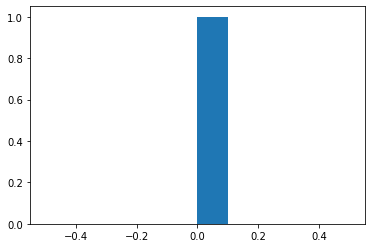

In [32]:
plt.hist(cell_rotations[:, 1])

In [33]:
# # Generate coordinates for square grid of cells
# pos = np.arange(-225, 226, 25)
# # pos = np.zeros(np.shape(temp_pos))
# # pos[1:10] = temp_pos[:9]
# # pos[10:] = temp_pos[10:]

In [34]:
# n = 1
# cell_locations[0] = [15, 0, 0]
# cell_rotations[0] = [0, 0, 0]
# for ypos in pos:
#     for zpos in pos:
#         cell_locations[n] = [15, ypos, zpos]
#         cell_rotations[n] = [0, 0, 0]
#         n += 1
        
# cell_locations[180:200]

In [35]:
# # Set custom location/rotation values
# for i in range(template_params['n']):
#     # Translation
#     cell_locations[i] = [15, i*5, 0]
#     cell_rotations[i] = [0, 0, 0]
    
#     # Rotation
# #     cell_locations[i] = [15, 0, 0]
# #     cell_rotations[i] = [i*2*np.pi/template_params['n'], 0, 0]
# cell_locations[0] = [15, 0, 0]
# cell_rotations[0] = [0, 0, 0]

# cell_locations[1] = [15, 0, 15]
# cell_rotations[1] = [0, 0, 0]
#cell_locations[0] = [15, 0, 0]
#cell_rotations[0] = [0, 0, np.pi/2]
#cell_locations[1] = [15, 0, 0]
#cell_rotations[1] = [0, 0, np.pi/2]

# Initialize variables separately so process can be stopped and started without deleting information
templates, templates_mags, template_locations, template_rotations, template_celltypes = [], [], [], [], []
i = 0
j = 0

In [36]:
# Generate templates of the electrode and magnetic responses to the cells in n random different positions

while i in range(len(cell_temps)):
    j = 0
    while j in range(template_params['n']):
        cell = Path(mea_cells_folder) / cell_temps[i]
        index = i*template_params['n'] + j
        print("\n", str(index+1), " / ", str(num_cells))
        cell_loc = np.zeros((1, 3))
        cell_rot = np.zeros((1, 3))
        cell_loc[0] = cell_locations[index]
        cell_rot[0] = cell_rotations[index]
        eaps, locs, rots, mags = mr.ziad_simulate_magnetic_templates(cell,
                                                                     intra_save_folder='mearec_template_sims',
                                                                     params=template_params,
                                                                     cell_locations = cell_loc,
                                                                     cell_rotations = cell_rot,
                                                                     verbose=True)
        
#         cell = "/Users/Ziad/Documents/School/Stanford/Rotations/Poon/NEURON/MorphologyFiles/soma_and_axon5"
#         eaps, locs, rots, mags = mr.ziad_simulate_magnetic_templates(cell,
#                                                                      intra_save_folder='mearec_template_sims10',
#                                                                      params=template_params,
#                                                                      cell_locations = cell_loc,
#                                                                      cell_rotations = cell_rot,
#                                                                      straight_cell = True,
#                                                                      verbose=True)
        # find cell type
        cell_type = None
        for k, v in cell_types.items():
            if k in str(cell):
                cell_type = v
                break
        print("Cell", cell, "is", cell_type)

        # if first cell, initialize the arrays
        if len(templates) == 0:
            templates = eaps
            template_mags = mags
            template_locations = locs
            template_rotations = rots
            template_celltypes = np.array([cell_type]*len(eaps))
        else:
            templates = np.vstack((templates, eaps))
            template_mags = np.vstack((template_mags, mags))
            template_locations = np.vstack((template_locations, locs))
            template_rotations = np.vstack((template_rotations, rots))
            template_celltypes = np.concatenate((template_celltypes, np.array([cell_type]*len(eaps))))
        
        j += 1
    i += 1
    
# Negate EAP generated by non-soma compartments so they can be detected by negative thresholding in sorter
if template_params['deactivate'] == 'Soma':
    templates = templates*-1

NEURON: bAC217_biophys : a template cannot be redefined
 in biophysics.hoc near line 33
 begintemplate bAC217_biophys
                            ^
        xopen("biophysics.hoc")
      execute1("{xopen("bi...")
    load_file(1, "biophysics.hoc")



 1  /  1
[[15.  0.  0.]]
[[1.57079633 0.         0.        ]]
Imem files:  []
Mechanisms already loaded from path: /Users/Ziad/.config/mearec/1.7.2/cell_models/MEArecLinearCells/mods.  Aborting.
	1 
	1 
	1 
template bAC217_L5_MC_cc2a170ef6 exist already
Morphology:  morphology/C040601.asc
Type:  <class 'str'>
Morphology is a string
Ziad Flatten Position:  [15.  0.  0.]
Ziad Faltten Rotation:  [1.57079633 0.         0.        ]
Input weight: 0.25 - Num Spikes: 13
1: i_spikes:  (12, 193, 224)
1: v_spikes:  (12, 224)
Extracellular simulation: /Users/Ziad/.config/mearec/1.7.2/cell_models/MEArecLinearCells/L5_MC_bAC217_1
Deactivate parameter:  None
Mechanisms already loaded from path: /Users/Ziad/.config/mearec/1.7.2/cell_models/MEArecLinearCells/mods.  Aborting.
template bAC217_L5_MC_cc2a170ef6 exist already
Morphology:  morphology/C040601.asc
Type:  <class 'str'>
Morphology is a string
Imem file:  mearec_template_sims/imem_12_L5_MC_bAC217_1.npy
Cell L5_MC_bAC217_1 extracellular spikes to

In [37]:
# Inspect properties of template

print(templates.shape)               # (#cells * n, #electrodes, EAP length)
print(template_mags.shape)           # (#cells * n, #electrodes, 3, EAP length)
print(template_locations.shape)      # (#cells * n, [x, y, z])
print(template_rotations.shape)      # (#cells * n, [x_rot, y_rot, z_rot])
print(template_celltypes.shape)      # (#cells * n, )
print(mea_name)

print(np.max(np.abs(template_mags)))

(1, 10000, 224)
(1, 10000, 3, 224)
(1, 3)
(1, 3)
(1,)
10000MEA30
2.5606941282678422e-11


In [25]:
all_diffs = np.zeros((128, 3, 224))
diffs = []
for i in range(128):
    for j in range(1):
        for k in range(224):
            diff = (original_mags[0][i][j][k] - template_mags[0][i][j][k])*1e12
            all_diffs[i, j, k] = diff
            diffs.append(diff)

In [26]:
peaks = []
avgs = []
for i in range(10):
    a = (np.sum(template_mags[i]**2, axis=2) - np.sum(original_mags[i]**2, axis=2))/np.sum(original_mags[i]**2, axis=2)
    peaks.append(np.max(abs(a)))
    avgs.append(np.mean(abs(a)))
    print("Peak: ", np.max(abs(a)), " Average: ", np.mean(abs(a)))
    
peaks = np.array(peaks)
avgs = np.array(avgs)

Peak:  0.011809347847808469  Average:  0.0014482974942703957
Peak:  0.047627396914499985  Average:  0.0051801457451425325
Peak:  0.02171204051061133  Average:  0.0045680185554485735
Peak:  0.07132093137060336  Average:  0.008486083741655529
Peak:  0.0  Average:  0.0
Peak:  0.0  Average:  0.0
Peak:  0.027655995972692127  Average:  0.004332672487569821
Peak:  0.05216145452627435  Average:  0.006924953446953708
Peak:  0.025009557723838692  Average:  0.004743991393787441
Peak:  0.008961841986610593  Average:  0.0016399585526452798


In [34]:
peaks = []
avgs = []
for i in range(10):
    a = (np.sum(template_mags[i]**2, axis=2) - np.sum(original_mags[i]**2, axis=2))/np.sum(original_mags[i]**2, axis=2)
    peaks.append(np.max(abs(a)))
    avgs.append(np.mean(abs(a)))
    print("Peak: ", np.max(abs(a)), " Average: ", np.mean(abs(a)))
    
peaks = np.array(peaks)
avgs = np.array(avgs)

Peak:  0.011809347847808469  Average:  0.0014482974942703957
Peak:  0.05379159924770646  Average:  0.006796746875771677
Peak:  0.0  Average:  0.0
Peak:  0.005845142187467736  Average:  0.0010625018828294489
Peak:  0.02111107273409497  Average:  0.004042467601043931
Peak:  0.021055188036465923  Average:  0.004418892307898218
Peak:  0.0  Average:  0.0
Peak:  0.0  Average:  0.0
Peak:  0.0  Average:  0.0
Peak:  0.008961841986610593  Average:  0.0016399585526452798


In [53]:
peaks = []
avgs = []
for i in range(50):
    a = (np.sum(template_mags[i]**2, axis=2) - np.sum(original_mags[i]**2, axis=2))/np.sum(original_mags[i]**2, axis=2)
    peaks.append(np.max(abs(a)))
    avgs.append(np.mean(abs(a)))
    print("Peak: ", np.max(abs(a)), " Average: ", np.mean(abs(a)))
    
peaks = np.array(peaks)
avgs = np.array(avgs)

Peak:  0.04209241322496838  Average:  0.0037020229137230518
Peak:  0.047627396914499985  Average:  0.0051801457451425325
Peak:  0.0  Average:  0.0
Peak:  0.0  Average:  0.0
Peak:  0.0  Average:  0.0
Peak:  0.021055188036465923  Average:  0.004418892307898218
Peak:  0.0362477644117601  Average:  0.005823871156503498
Peak:  0.0  Average:  0.0
Peak:  0.025009557723838692  Average:  0.004743991393787441
Peak:  0.017209980927943874  Average:  0.004433124428910673
Peak:  0.025581093189361744  Average:  0.004179794240429642
Peak:  0.0  Average:  0.0
Peak:  0.006065986976600981  Average:  0.0019968960862017777
Peak:  0.0  Average:  0.0
Peak:  0.04759818201536689  Average:  0.008659266082448068
Peak:  0.005958050624247034  Average:  0.0010767747105595127
Peak:  0.010064156224827614  Average:  0.0034890582216625244
Peak:  0.0  Average:  0.0
Peak:  0.016895654019687973  Average:  0.0042545804721397205
Peak:  0.05318665585337148  Average:  0.007890145943325433
Peak:  0.0  Average:  0.0
Peak:  0.02

(array([20.,  5.,  3.,  3.,  6.,  6.,  3.,  1.,  0.,  3.]),
 array([0.        , 0.00086593, 0.00173185, 0.00259778, 0.00346371,
        0.00432963, 0.00519556, 0.00606149, 0.00692741, 0.00779334,
        0.00865927]),
 <BarContainer object of 10 artists>)

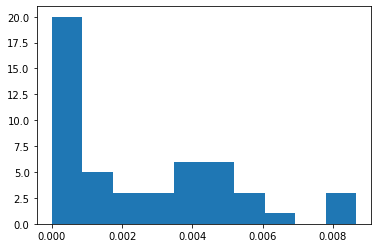

In [55]:
plt.hist(avgs)

In [58]:
idx = np.argmax(abs(all_diffs))
np.unravel_index(idx, np.shape(all_diffs))

(19, 0, 60)

In [57]:
diffs = np.array(diffs)
diffs = np.sort(-1*abs(diffs))
diffs[1:100]

array([-0.81950696, -0.79026842, -0.7743185 , -0.69693183, -0.67020788,
       -0.64911729, -0.64504802, -0.62953042, -0.57547276, -0.56806708,
       -0.55359074, -0.55160808, -0.54573007, -0.5433954 , -0.45484818,
       -0.41275729, -0.39904115, -0.38881603, -0.38798555, -0.38765754,
       -0.38256224, -0.35633479, -0.35437221, -0.3541117 , -0.34556091,
       -0.33597779, -0.32247372, -0.31539958, -0.30925382, -0.30598601,
       -0.27958586, -0.27500061, -0.27499981, -0.26619449, -0.26588643,
       -0.25235893, -0.24996482, -0.24829786, -0.24728999, -0.24611323,
       -0.24463177, -0.24374716, -0.24197597, -0.24106847, -0.24035779,
       -0.23785763, -0.23615833, -0.23411541, -0.23370767, -0.22572196,
       -0.2256459 , -0.22457049, -0.22324828, -0.22243295, -0.22086677,
       -0.21943465, -0.21796545, -0.21394085, -0.21286339, -0.21235247,
       -0.2106569 , -0.2099614 , -0.20778856, -0.2067195 , -0.2045308 ,
       -0.2036799 , -0.20196402, -0.20074919, -0.19759506, -0.19

In [62]:
print(template_mags[0, 19, 0, 60])
print(original_mags[0, 19, 0, 60])

-4.507986905390942e-12
-3.6386913399499556e-12


Real morph


/var/folders/df/rk7rf_5s4253kn_8sb19p5x80000gn/T/ipykernel_59717/3837063619.py:9: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax1.plot(electrodes.y, electrodes.z, '.', marker='o', markersize=3, color='k', zorder=0)


AttributeError: 'PosixPath' object has no attribute 'get_pt3d_polygons'

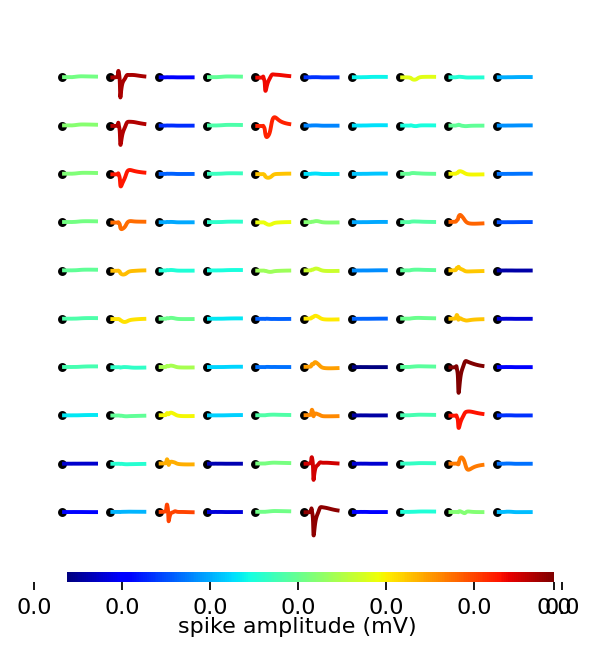

In [59]:
t = np.arange(0, 7, 0.03125)
mea = mu.return_mea("100MEA75")
electrodes = LFPy.RecExtElectrode(cell, probe=mea)
fig = plotstuff2(cell, t, template_mags[0][0:100, 0, :], electrodes, 0, False, True, 40, 8)

Real morph


/var/folders/df/rk7rf_5s4253kn_8sb19p5x80000gn/T/ipykernel_59717/3837063619.py:9: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax1.plot(electrodes.y, electrodes.z, '.', marker='o', markersize=3, color='k', zorder=0)


AttributeError: 'PosixPath' object has no attribute 'get_pt3d_polygons'

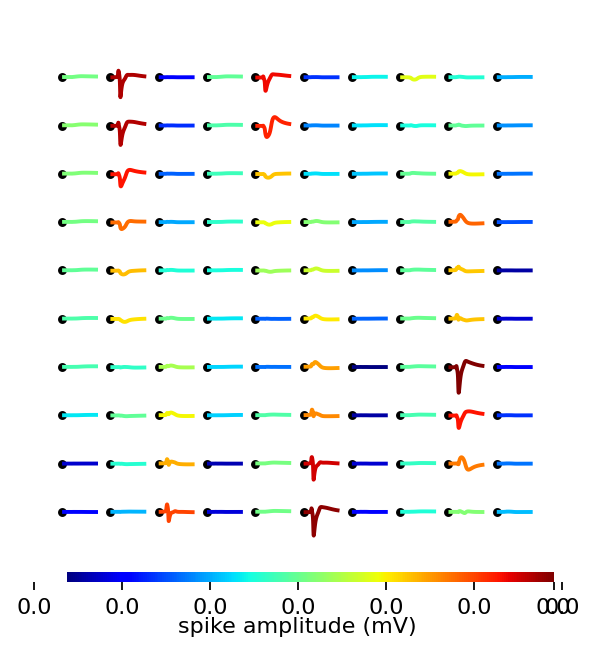

In [60]:
t = np.arange(0, 7, 0.03125)
mea = mu.return_mea("100MEA75")
electrodes = LFPy.RecExtElectrode(cell, probe=mea)
fig = plotstuff2(cell, t, original_mags[0][0:100, 0, :], electrodes, 0, False, True, 40, 8)

In [41]:
#First run
print(np.shape(template_mags[0]))
print(np.shape(original_mags[0]))
print(template_mags[0][0][0][1:10])
print(original_mags[0][0][0][1:10])
#print(np.max(template_mags[0] - original_mags[0]))

(128, 3, 224)
(128, 3, 224)
[-9.13420739e-15 -9.13501704e-15 -9.13583397e-15 -9.13665828e-15
 -9.13749009e-15 -9.13832952e-15 -9.13917671e-15 -9.14003185e-15
 -9.14089512e-15]
[-9.13469248e-15 -9.13550070e-15 -9.13631614e-15 -9.13713891e-15
 -9.13796912e-15 -9.13880689e-15 -9.13965235e-15 -9.14050567e-15
 -9.14136703e-15]


In [59]:
temp_idx = 10
idx = 20
for idx in range(100):
    # plt.plot(templates[temp_idx, idx])
    # plt.plot(lfp_nosoma[temp_idx, idx])
    # plt.plot(lfp_noaxon[temp_idx, idx])
    # plt.legend(['All', 'No Soma', 'Only Soma'])

    # plt.figure()
    plt.plot(template_mags[temp_idx, idx, 0])
    # plt.plot(B_nosoma[temp_idx, idx, 0])
    # plt.plot(B_noaxon[temp_idx, idx, 0])
    # plt.legend(['All', 'No Soma', 'Only Soma'])

IndexError: index 10 is out of bounds for axis 0 with size 3

In [60]:
np.shape(template_mags)

(3, 100, 3, 224)

In [38]:
# Create template generator with template information and save it

temp_dict = {'templates': templates, 
             'locations': template_locations, 
             'rotations': template_rotations,
             'celltypes': template_celltypes,
             'mags': template_mags}
info = {}
info['params'] = template_params
info['electrodes'] = mu.return_mea_info(template_params['probe'])

tempgen = mr.TemplateGenerator(temp_dict=temp_dict, info=info)

#mr.plot_templates(tempgen)

n_per_cell = template_params['n']
#delta = int(cell_locations[1][2])
if 'Neuropixel' in mea_name:
    radius = template_params['npixel_radius']

noise_string = ''
if neuropixel_noise == True:
    noise_string = 'noise_'
    radius_low = template_params['npixel_radius_noise'][0]
    radius_high = template_params['npixel_radius_noise'][1]
    
ncells = template_params['n']
#template_folder = f'ziad_mearec_templates/mag_templates_flattened_cells2-3_radius{radius}_zlim{zlim}_{mea_name}_no_axon.h5'
#template_folder = f'ziad_mearec_templates/mag_templates_flattened_noise_n{ncells}_cells2-3_radius{radius_low}-{radius_high}_zlim_{zlim[0]}_{zlim[1]}_{mea_name}.h5'
#template_folder = f'ziad_mearec_templates/mag_templates_flattened_{noise_string}cells2-3_xlim{noise_xlim}_ylim{noise_ylim}_zlim{zlim}_{mea_name}.h5'
#template_folder = f'ziad_mearec_templates/mag_templates_flattened_cells2-3_n200_no-axon_{mea_name}.h5'

#template_folder = f'ziad_mearec_templates/mag_templates_flattened_cell5_origin_{mea_name}.h5'
#template_folder = f'ziad_mearec_templates/mag_templates_flattened_5-25bound_4-6cells_n{n_per_cell}_{mea_name}_Ex.h5'
#template_folder = f'ziad_mearec_templates/mag_templates_flattened_x15_cell2_rotate_n{n_per_cell}_{mea_name}.h5'
#template_folder = f'ziad_mearec_templates/mag_templates_flattened_2cells_{delta}delta_{mea_name}.h5'
#template_folder = f'ziad_mearec_templates/mag_templates_flattened_rotation_{int(360/n_per_cell)}degrees_{mea_name}.h5'
#template_folder = f'ziad_mearec_templates/mag_templates_flattened_xytranslation_{n_per_cell}Cells_{25}um_{mea_name}.h5'
#template_folder = f'ziad_mearec_templates/mag_templates_flattened_0-2cells_zlim285_n{n_per_cell}_{mea_name}.h5'
#template_folder = f'ziad_mearec_templates/mag_templates_flattened_5-25bound_straight2_n{n_per_cell}_{mea_name}.h5'

template_folder = f'ziad_mearec_templates/mag_templates_flattened_cell1_origin_{mea_name}.h5'
print(template_folder)
mr.save_template_generator(tempgen=tempgen, filename=template_folder, magnetic = True)



ziad_mearec_templates/mag_templates_flattened_cell1_origin_10000MEA30.h5

Saved  templates in ziad_mearec_templates/mag_templates_flattened_cell1_origin_10000MEA30.h5 



In [ ]:
mr.plot_templates(tempgen, magnetic=True, dim=0)

In [ ]:
mr.plot_templates(tempgen, magnetic=False, dim=0)

In [145]:
# template_id = 30
# print(tempgen.locations[template_id])
# #mr.plot_templates(tempgen, template_ids = template_id)
# #mr.plot_templates(tempgen, template_ids = template_id, magnetic = True, dim = 0)
# #mr.plot_templates(tempgen, template_ids = template_id, magnetic = True, dim = 1)
# mr.plot_templates(tempgen, template_ids = template_id, magnetic = True, dim = 2)

In [146]:
# temp1 = templates[0] / np.max(np.abs(templates))
# temp2 = templates[1] / np.max(np.abs(templates))

# print("V Correlation Peak:", np.max(np.sum(temp1 * temp2, axis=0)))

# for dim in range(3):
#     #print("Max: ", np.max((template_mags[0, :, dim] / np.max(np.abs(template_mags[:, :, dim])))))
#     #print("Min: ", np.min((template_mags[0, :, dim] / np.max(np.abs(template_mags[:, :, dim])))))
#     temp1 = template_mags[0, :, dim] / np.max(np.abs(template_mags[:, :, dim]))
#     temp2 = template_mags[1, :, dim] / np.max(np.abs(template_mags[:, :, dim]))
#     fields = ['Bx', 'By', 'Bz']
#     print(fields[dim], "Correlation Peak:", np.max(np.sum(temp1 * temp2, axis=0)))

In [46]:
cell_rotations

array([[2.35619449, 0.        , 0.        ],
       [3.52698218, 0.        , 0.        ],
       [2.35868098, 0.        , 0.        ]])

In [41]:
# PLOT CELL RECORDING
#cell_temps = ['L5_UTPC_cADpyr232_1']

# Which cell template (size: dim 0 of templates)
template_id = 2

# Which cell type (calculate based on ID of template and number of iterations per cell type)
cell_model_id = int(np.floor(template_id / template_params['n']))

#cell_temps = ['L5_DBC_bAC217_1']
#cell_model_id = 0
print(cell_model_id)
cell_model_folder = Path(mea_cells_folder) / cell_temps[cell_model_id]
cell_name = str(cell_model_folder).partition('MEArecLinearCells/')[-1]

# Get cell type folder
print("Cell Model: ", cell_model_folder)
cell_model_folder = Path(cell_model_folder)

# Load cell and position and rotation info
T = template_params['sim_time'] * 1000
dt = template_params['dt']
cell = mr.return_bbp_cell(cell_model_folder, end_T=T, dt=dt, start_T=0)

#cell = mr.ziad_return_custom_cell("", end_T=T, dt=dt, start_T=0)
pos = cell_locations[template_id]
rot = cell_rotations[template_id]

#rot = [-np.pi/2, 0, 0]

#pos = tempgen.locations[template_id]
#rot = tempgen.rotations[template_id]

#pos = [0, -250, 0]
#rot = [0, 0, 0]

# Flatten geometry for either neuropixel array or regular MEA
if 'Neuropixels' in mea_name:
    cell = mr.ziad_adjust_morphology_neuropixel(cell, pos, rot)
else:
    cell = mr.ziad_flatten_geometry(cell, pos, rot, 10)

cell.set_pos(pos[0], pos[1], pos[2])
cell.set_rotation(rot[0], rot[1], rot[2])

# Get MEA 
mea = mu.return_mea(mea_name)
electrodes = LFPy.RecExtElectrode(cell, probe=mea)

dim = 2
mag = False
real_morph = True
scale_mult = 40
time_scale = 8
# data = tempgen.templates[template_id]
# if mag == True:
#     data = tempgen.mags[template_id, :, dim, :]
t = np.arange(0, 7, dt)
    
#fig = plotstuff2(cell, t, tempgen.templates[template_id], electrodes, dim, mag, real_morph, scale_mult, time_scale)
#fig = plotstuff2(cell, t, tempgen.mags[template_id, :, 0, :], electrodes, dim, mag, real_morph, scale_mult, time_scale)
#fig = plotstuff2(cell, t, tempgen.mags[template_id, :, 1, :], electrodes, dim, mag, real_morph, scale_mult, time_scale)
#fig = plotstuff2(cell, t, tempgen.mags[template_id, :, 2, :], electrodes, dim, mag, real_morph, scale_mult, time_scale)

0
Cell Model:  /Users/Ziad/.config/mearec/1.7.2/cell_models/MEArecLinearCells/L5_TTPC1_cADpyr232_1
Mechanisms already loaded from path: /Users/Ziad/.config/mearec/1.7.2/cell_models/MEArecLinearCells/mods.  Aborting.
template cADpyr232_L5_TTPC1_0fb1ca4724 exist already
Morphology:  morphology/dend-C060114A2_axon-C060114A5.asc
Type:  <class 'str'>
Morphology is a string
Ziad Neuropixel Adjust Position:  [  10.9969284    24.43524233 -182.36978473]
Ziad Neuropixel Adjust Rotation:  [-1.65952838e+00 -1.92463286e-03  4.06007603e+00]
[35.99692535  5.99692535 59.73701781 12.1481353 ]


/var/folders/df/rk7rf_5s4253kn_8sb19p5x80000gn/T/ipykernel_86922/4186138331.py:16: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.plot(X, Y, '.', marker='o', markersize=3, color='k', zorder=0)
/var/folders/df/rk7rf_5s4253kn_8sb19p5x80000gn/T/ipykernel_86922/4186138331.py:17: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.plot([lim, lim, -lim, -lim], [lim, -lim, lim, -lim], '.', marker='o', markersize=1, color='blue')
/var/folders/df/rk7rf_5s4253kn_8sb19p5x80000gn/T/ipykernel_86922/4186138331.py:17: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.plot([lim, lim, -lim, -lim], [lim, -lim, lim, -lim], '.', marker='o', markersize=1, color='blue')


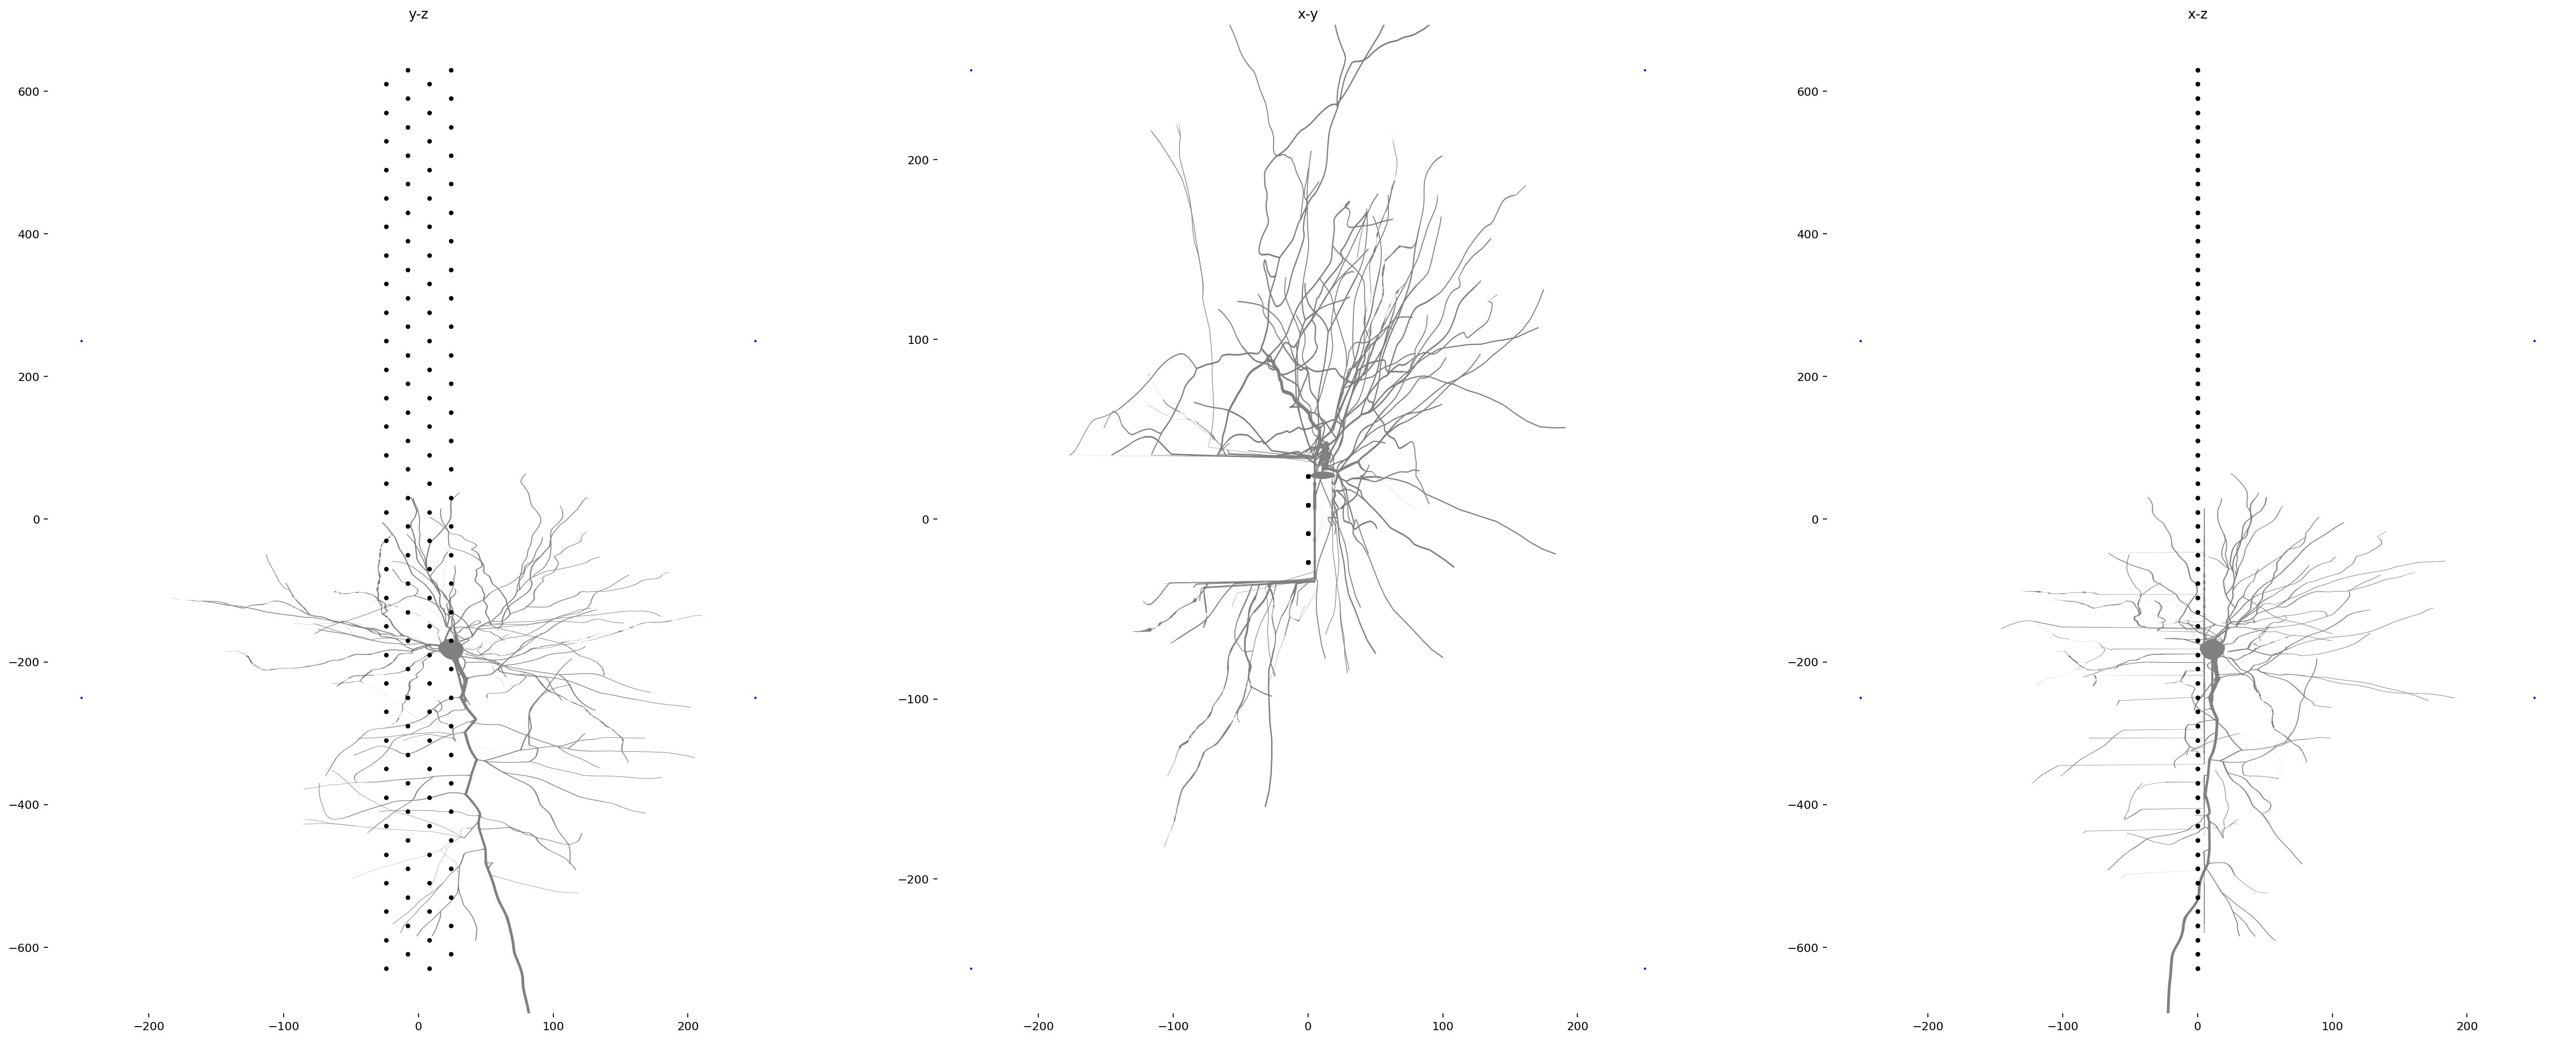

In [42]:
fig = plotcell_3planes(cell, electrodes, 250, plot_electrodes=True)

In [96]:
start_idx = 251
end_idx = 500
for idx in [-1, 0, 2]:
    if idx == -1:
        data = tempgen.templates[0, start_idx:]
    else:
        data = tempgen.mags[0, start_idx:, idx]

    max_vals = np.max(abs(data), axis=1) / np.max(abs(data))
    plt.plot(np.diff(np.log10(1*(max_vals)))/np.diff(np.log10(x)))
    
# plt.plot(np.max(abs(tempgen.mags[0, 251:, 0]), axis=1))
# plt.plot(np.max(abs(tempgen.mags[0, 251:, 2]), axis=1))

ValueError: zero-size array to reduction operation maximum which has no identity

In [15]:
np.shape(tempgen.mags[0, 251:])

(249, 3, 224)

/var/folders/df/rk7rf_5s4253kn_8sb19p5x80000gn/T/ipykernel_53907/4173142035.py:44: RuntimeWarning: invalid value encountered in log10
  log_vals = np.diff(np.log10(1*(max_vals)))/np.diff(np.log10(x))


1.0
1.0


1.0
0.991105476212881
0.967066975638963
0.9274395070357693
0.8726940942369932
0.804968400757561
0.7281523196113799
0.6466376649496192
0.5706683030274533
0.4948684362196458
0.4215731191044097
0.35613333663497143
0.29988038049232124
0.27517984503890464
0.28266793107815247
0.2864647380285311
0.28637193007595974
0.2829752325988525
0.27662672024126495
0.2667214854041741
0.253584002949264
0.23743634488983292
0.21876245489805876
0.20180391399703582
0.18670304837711146
0.19035150867749828
0.19516545051013337
0.19934921100298572
0.20270624818689656
0.20527912418338248
0.20697913649713706
0.20773921339471904
0.20749287270207506
0.20615651542387173
0.2036947973563683
0.1999919804421203
0.19505074547907764
0.18943389772806726
0.1839946477628126
0.1792378849525986
0.17503749149963627
0.17093175565116783
0.1672344806516424
0.16401973911304374
0.16099237678949024
0.15828571637947353
0.1558812830723894
0.15362623307510792
0.15121787111493812
0.1482614023243333
0.14459310550018842
0.140448424

/var/folders/df/rk7rf_5s4253kn_8sb19p5x80000gn/T/ipykernel_53907/4173142035.py:44: RuntimeWarning: invalid value encountered in log10
  log_vals = np.diff(np.log10(1*(max_vals)))/np.diff(np.log10(x))


1.0
1.0


1.0
0.9891263201893202
0.9490891081075075
0.8925400207227373
0.8867619846436602
0.9193237411874097
0.9158587625640356
0.8577235213102126
0.7914002272344793
0.7665021030834833
0.7976581282459133
0.8638357964904354
0.9188271996944489
0.9176729133411993
0.8552992199454741
0.7660488386045059
0.6852504360696252
0.6271720706411414
0.5877226907145986
0.5573756824240279
0.5262742707410822
0.49346893923744967
0.4652407241905678
0.44609364863440587
0.436401030185996
0.4349694314099998
0.4409350702538857
0.4523043020905425
0.46498771084190416
0.4744305408048344
0.48460161380378486
0.4965933692339755
0.502685501715182
0.49960115439817754
0.4990743365010227
0.5047640891356131
0.5070012174990992
0.5024307555772117
0.5015036183913569
0.5010059001414904
0.47538394126381345
0.4210592072055134
0.3778359166190864
0.364287273142789
0.3353018541594922
0.24070065723365014
0.14385072917008526
0.09958544978279694
0.09312387462058891
0.0931318231938137
0.09493199886415235
0.10886362793696752
0.119831

/var/folders/df/rk7rf_5s4253kn_8sb19p5x80000gn/T/ipykernel_53907/4173142035.py:44: RuntimeWarning: invalid value encountered in log10
  log_vals = np.diff(np.log10(1*(max_vals)))/np.diff(np.log10(x))


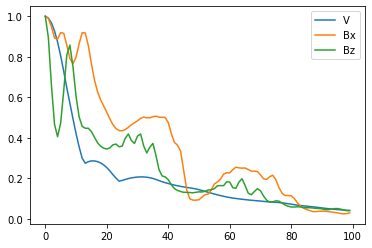

In [47]:
radial = False
y_starts = [-299, -277, -267]

z_starts1 = [1, 7, 1]
z_starts = [1, 7, 1]
y_starts2 = [-299, -277, -267]

# y_starts = [11, 301, 301]
# z_starts1 = [19, 15, 1]

# y_starts2 = [11, 301, 301]
# z_starts = [19, 19, 19]
template_id = 0

iters = 1
all_max_vals = np.zeros((3, iters, 100))
for k in range(iters):
    for j, i in enumerate([-1, 0, 2]):
        if radial:
            y_start = y_starts[j]
            z_start = z_starts1[j]

            start_index = int((y_start + 499)/2*500 + (z_start + 499)/2)
            end_index = start_index + 100
            idxs = slice(start_index, end_index)

        else:
            y_start = y_starts2[j]
            z_start = z_starts[j]+k*2

            start_index = int((y_start + 499)/2*500 + (z_start + 499)/2)
            num_steps = 100
            idxs = slice(start_index, start_index+num_steps*500, 500)

        if i == -1:
            data = tempgen.templates[template_id, idxs, :]
            all_data = tempgen.templates[template_id]
        else:
            data = tempgen.mags[template_id, idxs, i, :]
            all_data = tempgen.mags[template_id, :, i, :]

        max_vals = np.max(abs(data), axis=1) / np.max(abs(all_data))
        
        log_vals = np.diff(np.log10(1*(max_vals)))/np.diff(np.log10(x))
        print(max(max_vals))
        print(max_vals[0])
        print()
        print()
        for val in max_vals:
            print(val)
        print()
        #max_vals = max_vals / np.max(max_vals)
        all_max_vals[j, k] = max_vals
        if radial == False:
            plt.plot(max_vals)
        else:
            plt.plot(np.diff(np.log10(1*(max_vals)))/np.diff(np.log10(x)))

#plt.plot(np.diff(np.log10(r1)))
#plt.plot(np.diff(np.log10(r2)))
plt.legend(['V', 'Bx', 'Bz'])

In [56]:
np.unravel_index(np.argmax(abs(tempgen.mags[0, :, 2])), np.shape(tempgen.mags[0, :, 0]))

(202749, 66)

In [57]:
202749 / 500

405.498

/var/folders/df/rk7rf_5s4253kn_8sb19p5x80000gn/T/ipykernel_53907/300866181.py:14: RuntimeWarning: invalid value encountered in log10
  logx = np.log10(x)


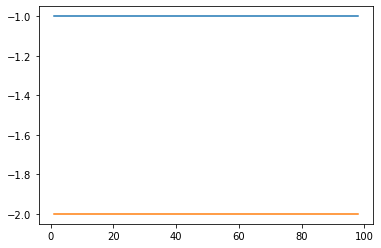

In [15]:
r2 = [1/(1e-6**2)]
r1 = [1/1e-6]
x = [1-6]
for i in range(1, 100):
    dist = 2e-6*i + 1e-6
    r2.append(1/dist**2)
    r1.append(1/dist)
    x.append(2e-6*i+1e-6)
    
x = np.array(x)
r1 = np.array(r1)
r2 = np.array(r2)

logx = np.log10(x)
logx_diff = logx[1:]-logx[:-1]

logr1 = np.log10(r1)
logr1_diff = logr1[1:]-logr1[:-1]

logr2 = np.log10(r2)
logr2_diff = logr2[1:]-logr2[:-1]

plt.plot(logr1_diff/logx_diff)
plt.plot(logr2_diff/logx_diff)

In [359]:
np.shape(x[:-1])

(99,)

In [305]:
idx = 2
mean = np.mean(all_max_vals[idx], axis=0)
std = np.std(all_max_vals[idx], axis=0)
for i in range(len(mean)):
    print(mean[i])

1.0
0.9155985417244785
0.8062224301947678
0.712294131545908
0.6524001531518205
0.6288359485327959
0.6330095638788049
0.648970902480579
0.6602692806902682
0.6581102460019925
0.6442267586265017
0.6262295810511349
0.6106024957383878
0.6026075759080468
0.5954997939930148
0.5853093485804652
0.5704993820093368
0.5518446742719649
0.5308106832527008
0.5083781168382431
0.48506780608785754
0.46123934854790805
0.4370975247848734
0.41343132432882584
0.3922990457598806
0.3735286999851861
0.357711275622615
0.3441251697822395
0.3320442128609852
0.3216340384228973
0.3138417097998431
0.3093175610445171
0.30775610936682674
0.31026031384869057
0.3164380957410231
0.3257809981285047
0.3399910766750862
0.36469214296043306
0.4026160366636057
0.4390614805273897
0.45519893912139525
0.46142005534176034
0.4823071702043024
0.5063690481593882
0.5045535356804108
0.4876300898223756
0.4778566487800063
0.46076148822098456
0.4316432997069786
0.4071081387945086
0.3844375189215264
0.35223096555038597
0.3194261301164063
0

In [312]:
%run ZIAD_MEARecHelperFunctions.ipynb

/var/folders/df/rk7rf_5s4253kn_8sb19p5x80000gn/T/ipykernel_34237/1823449323.py:13: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.plot(X, Y, '.', marker='o', markersize=3, color='k', zorder=0)
/var/folders/df/rk7rf_5s4253kn_8sb19p5x80000gn/T/ipykernel_34237/1823449323.py:14: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.plot([lim, lim, -lim, -lim], [lim, -lim, lim, -lim], '.', marker='o', markersize=1, color='blue')
/var/folders/df/rk7rf_5s4253kn_8sb19p5x80000gn/T/ipykernel_34237/1823449323.py:14: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.plot([lim, lim, -lim, -lim], [lim, -lim, lim, -lim], '.', marker='o', markersize=1, color='blue')


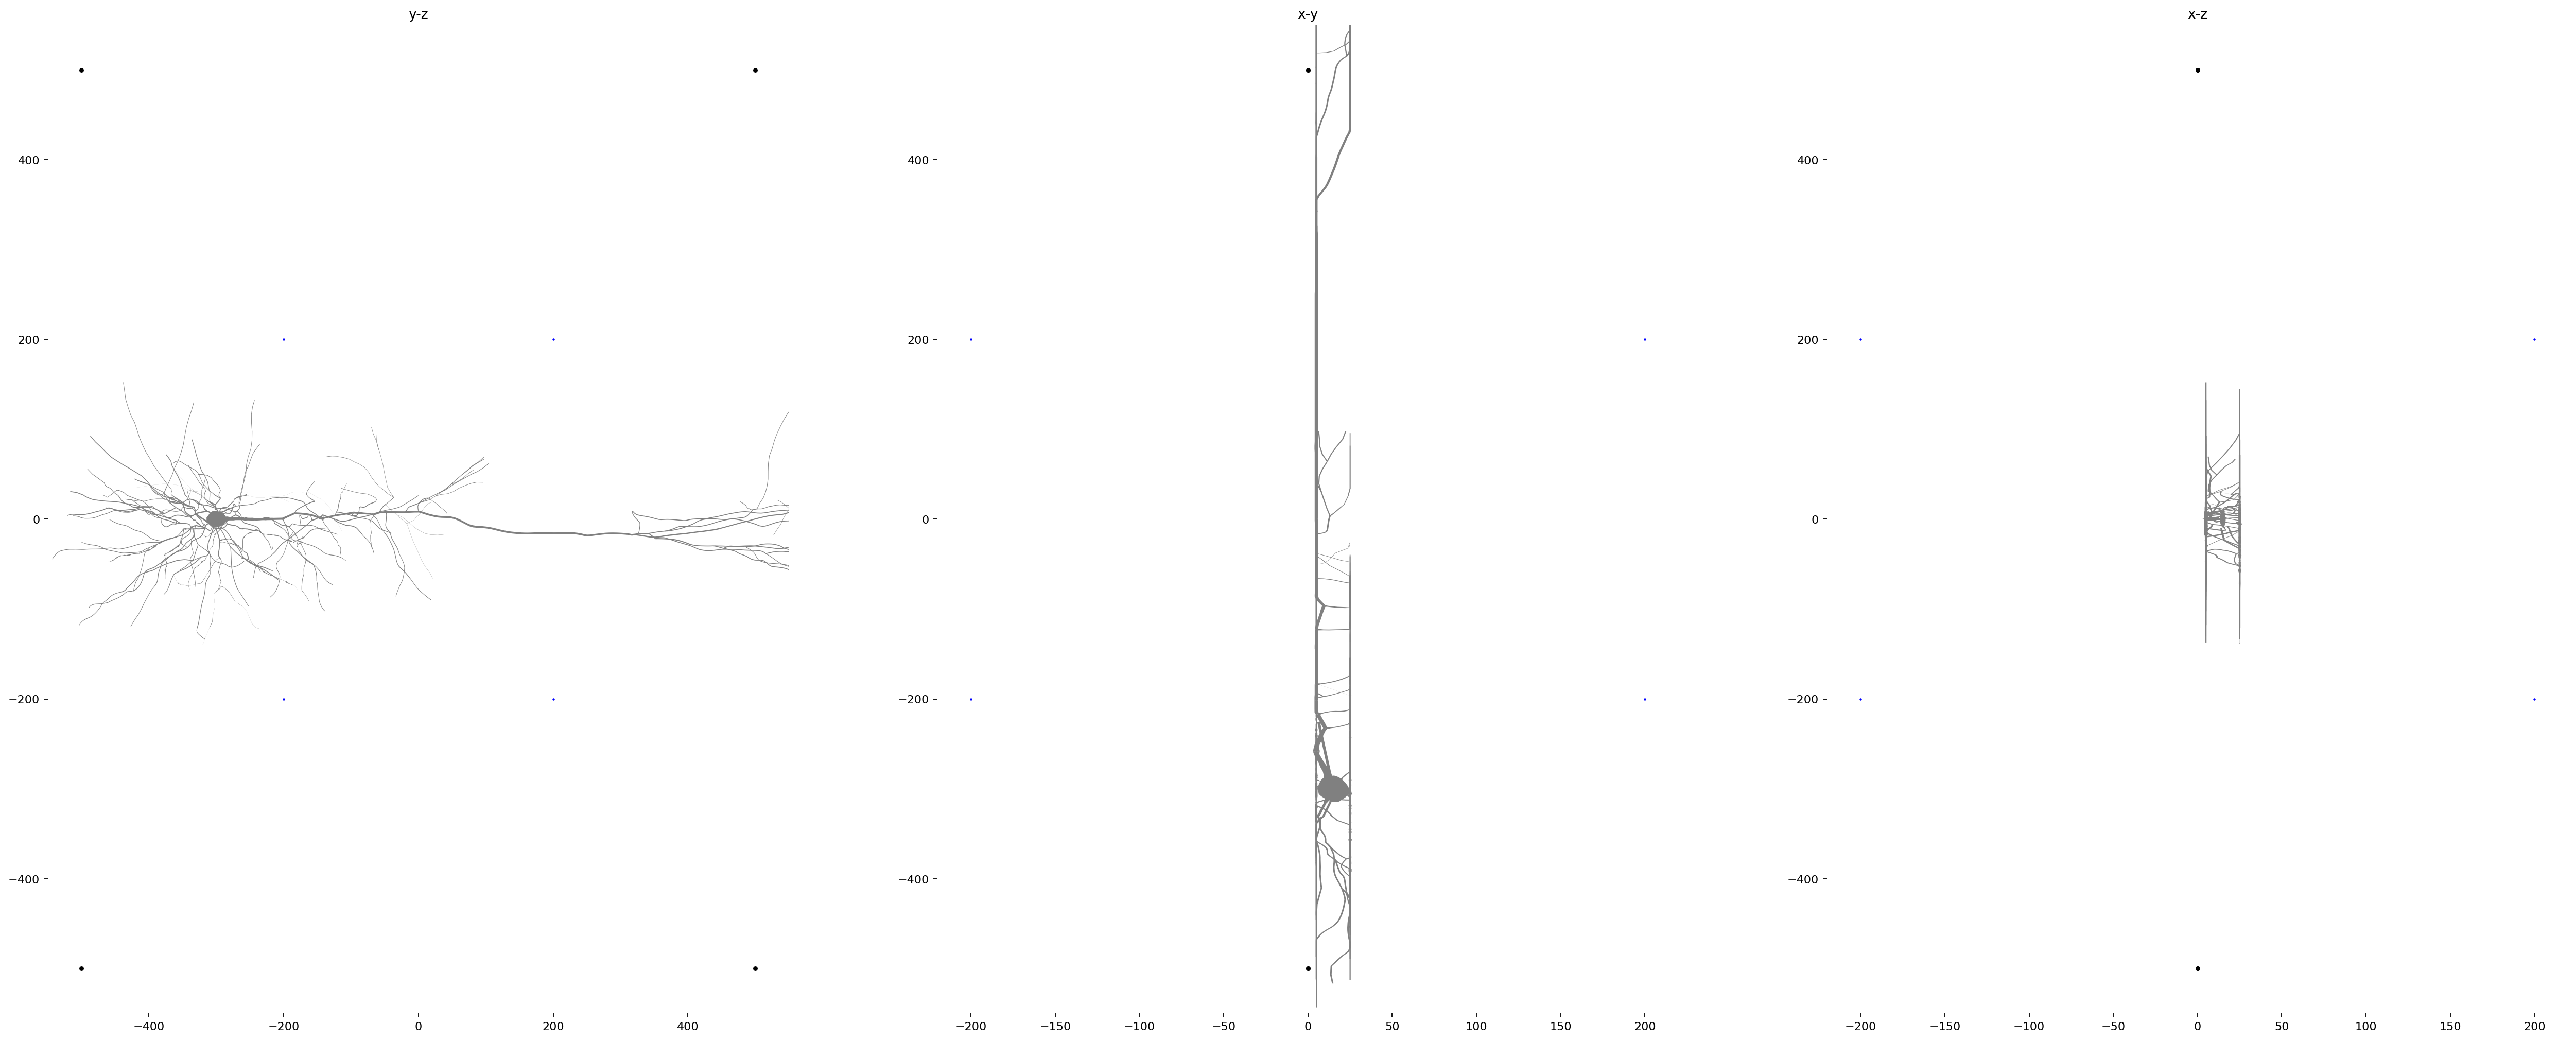

In [313]:
shank = [-25, 0, -35, 35, -650]
#cell = mr.ziad_adjust_morphology_neuropixel(cell, pos, rot)
#cell = mr.ziad_flatten_geometry(cell, pos, rot, 10)
#mea_name = 'Neuropixels-128'
mea_name = '4MEA1000'
mea = mu.return_mea(mea_name)
electrodes = LFPy.RecExtElectrode(cell, probe=mea)

#cell.set_pos(0, 0, 0)
#cell.set_rotation(0, 0, -0.05)
#cell.set_rotation(0, 1.5, -0.05)
fig = plotcell_3planes(cell, electrodes, 200)

In [273]:
electrodes.y

array([-337.5, -337.5, -337.5, -337.5, -337.5, -337.5, -337.5, -337.5,
       -337.5, -337.5, -262.5, -262.5, -262.5, -262.5, -262.5, -262.5,
       -262.5, -262.5, -262.5, -262.5, -187.5, -187.5, -187.5, -187.5,
       -187.5, -187.5, -187.5, -187.5, -187.5, -187.5, -112.5, -112.5,
       -112.5, -112.5, -112.5, -112.5, -112.5, -112.5, -112.5, -112.5,
        -37.5,  -37.5,  -37.5,  -37.5,  -37.5,  -37.5,  -37.5,  -37.5,
        -37.5,  -37.5,   37.5,   37.5,   37.5,   37.5,   37.5,   37.5,
         37.5,   37.5,   37.5,   37.5,  112.5,  112.5,  112.5,  112.5,
        112.5,  112.5,  112.5,  112.5,  112.5,  112.5,  187.5,  187.5,
        187.5,  187.5,  187.5,  187.5,  187.5,  187.5,  187.5,  187.5,
        262.5,  262.5,  262.5,  262.5,  262.5,  262.5,  262.5,  262.5,
        262.5,  262.5,  337.5,  337.5,  337.5,  337.5,  337.5,  337.5,
        337.5,  337.5,  337.5,  337.5])

In [155]:
import random

shank = [-25, 0, -35, 35, -650]

xx = []
yy = []
zz = []
colors = []

for i, sec in enumerate(cell.allseclist):
    n3d = int(h.n3d(sec=sec))
    color = "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
    intersected = False
    two_bounds = None
    last_flat_bound = None
    for n in range(n3d):
        color = '#000000'
        x = cell.x3d[i][n]
        y = cell.y3d[i][n]
        z = cell.z3d[i][n]
        new_x = x
        new_y = y
        closest_bound = None
        if intersect_mea(x, y, z, shank):
            color = '#ff0000'
            intersected = True
            closest_bounds = calc_closest_bounds(shank, x, y)
            if two_bounds == None:
                two_bounds = closest_bounds[1:]
            new_x, new_y, closest_bound = get_new_coord(shank, x, y, list(closest_bounds[0]), two_bounds)
        if n > 0:
            midx, midy, midz = get_midpoint(cell.x3d[i][n], cell.y3d[i][n], cell.z3d[i][n],
                                      xx[-1], yy[-1], zz[-1])
            if intersect_mea(midx, midy, midz, shank) and last_flat_bound != None:
                bounds = [0, 1, 2, 3]
                bounds[0] = last_flat_bound
                bounds[last_flat_bound] = 0
                new_x, new_y, _ = get_new_coord(shank, x, y, bounds, two_bounds)
                color = "#00ff00"
                
        x = new_x
        y = new_y
        last_flat_bound = closest_bound
            
        xx.append(x)
        yy.append(y)
        zz.append(z)
        colors.append(color)
        #ax.scatter(cell.x3d[i][n], cell.y3d[i][n], cell.z3d[i][n], color=color)

xvals = np.arange(shank[0], shank[1]+0.1, 10)
yvals = np.arange(shank[2], shank[3]+0.1, 10)
zvals = np.arange(shank[4], 1500, 20)

for xval in xvals:
    for yval in yvals:
        for zval in zvals:
            xx.append(xval)
            yy.append(yval)
            zz.append(zval)
            colors.append('#0000ff')

In [260]:
def intersect_mea(x, y, z, shank):
    shankx1, shankx2 = shank[0:2]
    shanky1, shanky2 = shank[2:4]
    shankz = shank[4]
    
    if x > shankx1 and x < shankx2 and y > shanky1 and y < shanky2 and z > shankz:
        return True
    
    return False

def calc_closest_bounds(shank, x, y):
    dists = [0, 0, 0, 0]
    dists[0] = abs(x-shank[0])
    dists[1] = abs(x-shank[1])
    dists[2] = abs(y-shank[2])
    dists[3] = abs(y-shank[3])
    #print(dists)
    # Return ordered closest bounds, closest x-bound, closest y-bound
    return [np.argsort(dists), np.argmin(dists[0:2]), np.argmin(dists[2:4])+2]

def get_new_coord(shank, x, y, closest_bounds, allowed_bounds):
    # Find index of closest allowed bound
    closest_bound = allowed_bounds[0]
    if closest_bounds.index(allowed_bounds[0]) > closest_bounds.index(allowed_bounds[1]):
        closest_bound = allowed_bounds[1]
    new_x = x
    new_y = y
    if closest_bound in [0, 1]:
        new_x = shank[closest_bound]
    else:
        new_y = shank[closest_bound]
    return [new_x, new_y, closest_bound]

def get_midpoint(x1, y1, z1, x2, y2, z2):
    return [(x2-x1)/2, (y2-y1)/2, (z2-z1)/2]

def lineseg_dists(p, a, b):
    """Cartesian distance from point to line segment

    Edited to support arguments as series, from:
    https://stackoverflow.com/a/54442561/11208892

    Args:
        - p: np.array of single point, shape (2,) or 2D array, shape (x, 2)
        - a: np.array of shape (x, 2)
        - b: np.array of shape (x, 2)
    """
    # normalized tangent vectors
    d_ba = b - a
    d = np.divide(d_ba, (np.hypot(d_ba[:, 0], d_ba[:, 1])
                           .reshape(-1, 1)))

    # signed parallel distance components
    # rowwise dot products of 2D vectors
    s = np.multiply(a - p, d).sum(axis=1)
    t = np.multiply(p - b, d).sum(axis=1)

    # clamped parallel distance
    h = np.maximum.reduce([s, t, np.zeros(len(s))])

    # perpendicular distance component
    # rowwise cross products of 2D vectors  
    d_pa = p - a
    c = d_pa[:, 0] * d[:, 1] - d_pa[:, 1] * d[:, 0]

    return np.hypot(h, c)

def get_soma_closest_bound(shank, somapos):
    point = np.zeros((1, 2))
    a = np.zeros((4, 2))
    b = np.zeros((4, 2))

    point[0] = [somapos[0], somapos[1]]

    a[0] = [shank[0], shank[2]]
    b[0] = [shank[0], shank[3]]
    a[1] = [shank[1], shank[2]]
    b[1] = [shank[1], shank[3]]
    a[2] = [shank[0], shank[2]]
    b[2] = [shank[1], shank[2]]
    a[3] = [shank[0], shank[3]]
    b[3] = [shank[1], shank[3]]
    
    dists = lineseg_dists(point, a, b)
    print(dists)
    return np.argmin(dists)

def shift_coord(shank, x, y, soma_bound):
    new_x = x
    new_y = y
    if soma_bound < 2:
        new_x = shank[soma_bound]
    else:
        new_y = shank[soma_bound]
    return new_x, new_y

def check_illegal_coord(shank, x, y, soma_bound):
    # Determine if threshold is a max or min 
    threshold = shank[soma_bound]
    mult = 1
    if soma_bound % 2 == 1:
        mult = -1
    
    # Determine if point has to be between x bounds or y-bounds
    constraint_min = shank[0]
    constraint_max = shank[1]
    if soma_bound < 2:
        constraint_min = shank[2]
        constraint_max = shank[3]
        
    thresh_coord = y
    constraint_coord = x
    if soma_bound < 2:
        thresh_coord = x
        constraint_coord = y
        
    if mult*thresh_coord > mult*threshold:
        if constraint_coord > constraint_min and constraint_coord < constraint_max:
            return True
        
    return False
    

#def shift_coord()

In [236]:
xvals = np.arange(-50, 25, 5)
yvals = np.arange(-70, 70, 5)
soma = [-50, 50]

xx = []
yy = []
colors = []

soma_bound = get_soma_closest_bound(shank, soma)
for xval in xvals:
    for yval in yvals:
        x = xval
        y = yval 
        color = [0, 255, 0]
        illegal = check_illegal_coord(shank, xval, yval, soma_bound)
        if illegal:
            x, y = shift_coord(shank, xval, yval, soma_bound)
            color = [255, 0, 0]
        xx.append(x)
        yy.append(y)
        colors.append(color)



[29.15475947 52.20153254 88.60022573 29.15475947]


In [ ]:
shank = [-25, 0, -35, 35, -650]

xx = []
yy = []
zz = []
colors = []

soma_bound = get_soma_closest_bound(shank, soma)
for i, sec in enumerate(cell.allseclist):
    n3d = int(h.n3d(sec=sec))
    color = "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
    for n in range(n3d):
        

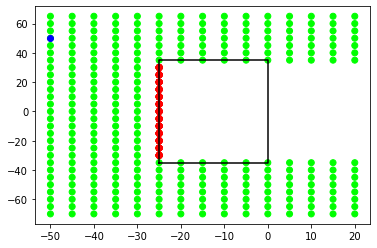

In [237]:
fig = plt.figure()
#plt.plot(shank)
shank_coords_x = [shank[0], shank[1], shank[1], shank[0], shank[0]]
shank_coords_y = [shank[2], shank[2], shank[3], shank[3], shank[2]]
plt.plot(shank_coords_x, shank_coords_y, c='black')
plt.scatter(xx, yy, c=np.array(colors)/255.0)
plt.scatter(soma[0], soma[1], c="#0000ff")

In [298]:
shank = [-25, 0, -35, 35, -650]

def adjust_morphology_neuropixel(shank, cell):
#     xx = []
#     yy = []
#     zz = []
#     colors = []

    soma_bound = get_soma_closest_bound(shank, cell.somapos[0:2])
    for i, sec in enumerate(cell.allseclist):
        n3d = int(h.n3d(sec=sec))
        for n in range(n3d):
            color = '#000000'
            x = cell.x3d[i][n]
            y = cell.y3d[i][n]
            z = cell.z3d[i][n]
            new_x = x
            new_y = y

            illegal = check_illegal_coord(shank, x, y, soma_bound)
            if illegal:
                new_x, new_y = shift_coord(shank, x, y, soma_bound)
                color = "#ff0000"

            cell.x3d[i][n] = new_x
            cell.y3d[i][n] = new_y
    
    return cell

#             xx.append(new_x)
#             yy.append(new_y)
#             zz.append(z)
#             colors.append(color)

#     cell._update_pt3d()

#     xvals = np.arange(shank[0], shank[1]+0.1, 10)
#     yvals = np.arange(shank[2], shank[3]+0.1, 10)
#     zvals = np.arange(shank[4], 1500, 20)

#     for xval in xvals:
#         for yval in yvals:
#             for zval in zvals:
#                 xx.append(xval)
#                 yy.append(yval)
#                 zz.append(zval)
#                 colors.append('#0000ff')

In [285]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter3d(x=[cell.somapos[0]], y=[cell.somapos[1]],
                           z=[cell.somapos[2]],
                           mode='markers',
                           marker=dict(color='purple',size=10)))
fig.add_trace(go.Scatter3d(x=xx, y=yy,
                           z=zz,
                           mode='markers',
                           marker=dict(color=colors,size=1)))

In [259]:
soma_bound

0

In [20]:
count = 0
for sec in h.allsec():
    print("Section: ", count, ", Segments: ", sec.n3d())
    for i in range(sec.n3d()):
        #print(sec.x3d(i))
        if h.x3d(i, sec=sec) > 0:
            print("Changing")
            x = 0
            y = h.y3d(i, sec=sec)
            z = h.z3d(i, sec=sec)
            diam = h.diam3d(i, sec=sec)
            h.pt3dchange(i, x, y, z, diam, sec=sec)
        #h.define_shape()
    count += 1



Section:  0 , Segments:  21
Section:  1 , Segments:  43
Section:  2 , Segments:  30
Section:  3 , Segments:  34
Section:  4 , Segments:  10
Section:  5 , Segments:  12
Section:  6 , Segments:  6
Section:  7 , Segments:  10
Section:  8 , Segments:  12
Section:  9 , Segments:  19
Section:  10 , Segments:  28
Section:  11 , Segments:  10
Section:  12 , Segments:  74
Section:  13 , Segments:  5
Section:  14 , Segments:  5
Section:  15 , Segments:  36
Section:  16 , Segments:  30
Section:  17 , Segments:  38
Section:  18 , Segments:  13
Section:  19 , Segments:  27
Section:  20 , Segments:  10
Section:  21 , Segments:  17
Section:  22 , Segments:  69
Section:  23 , Segments:  52
Section:  24 , Segments:  28
Section:  25 , Segments:  22
Section:  26 , Segments:  58
Section:  27 , Segments:  14
Section:  28 , Segments:  20
Section:  29 , Segments:  20
Section:  30 , Segments:  11
Section:  31 , Segments:  32
Section:  32 , Segments:  64
Section:  33 , Segments:  9
Section:  34 , Segments:  7


In [47]:
for i, sec in enumerate(cell.allseclist):
    n3d = int(h.n3d(sec=sec))
    for n in range(n3d):
        if cell.x3d[i][n] > 0:
            print("Change")
            cell.x3d[i][n] = 0
            h.pt3dchange(n,
                         0,
                         cell.y3d[i][n],
                         cell.z3d[i][n],
                         cell.diam3d[i][n], sec=sec)
    # let NEURON know about the changes we just did:
    h.define_shape()

cell._collect_geometry()


In [37]:
cell.x3d[0]

array([ 1.68536279e+00,  1.51682637e+00,  1.34829018e+00,  1.17975400e+00,
        1.01121757e+00,  8.42681385e-01,  6.74145199e-01,  5.05608774e-01,
        3.37072588e-01,  1.68536402e-01, -2.27065313e-08, -1.68536209e-01,
       -3.37072634e-01, -5.05608820e-01, -6.74145125e-01, -8.42681431e-01,
       -1.01121762e+00, -1.17975392e+00, -1.34829023e+00, -1.51682647e+00,
       -1.68536278e+00])

In [19]:
# ps = h.PlotShape(False)
# #ps.plot(plt)
# ps.plot(plotly).show()

In [14]:
def generate_single_recording(numcells, duration, noise, gdrive_folder, local_template_folder):
    #folder_id = get_folder_id(gdrive_folder) #Gets Google Drive folder ID
    
    rec_params = mr.get_default_recordings_params()
    rec_params['cell_types'] = {'excitatory': ['exc'], 'inhibitory': ['inh']}

    rec_params['spiketrains']['duration'] = duration # number of seconds to generate for
    rec_params['spiketrains']['n_exc'] = numcells # number of excitatory cells (randomly selected) to simulate
    rec_params['spiketrains']['n_inh'] = 0 # number of inhibitory cells (randomly selected) to simulate
    rec_params['templates']['min_dist'] = 1 # minimum distance cells must be from each other in um
    rec_params['templates']['min_amp'] = 30 # minimum amplitude? not sure what this is for
    rec_params['templates']['max_amp'] = 400
    rec_params['recordings']['noise_level'] = noise # noise level added in background

    recgen = mr.gen_recordings(params=rec_params, templates=local_template_folder, verbose=True, magnetic=True, a=False)
    
    return recgen

In [15]:
def generate_recording_files(numcells, duration, noise, count, gdrive_folder, local_template_folder):
    #folder_id = get_folder_id(gdrive_folder) #Gets Google Drive folder ID
    
    for i in range(0, 5):
        recgen = generate_single_recording(numcells, duration, noise, gdrive_folder, local_template_folder)
        
        filename = f'ziad_mearec_recordings/{gdrive_folder}/all_recordings_{numcells}cells_{duration}s_noise{noise}_{i}.h5'
        print("Saving recgen")
        mr.save_recording_generator(recgen=recgen, filename=filename)
        
        # Upload to Google Drive
#         print("Uploading recording to Gdrive")
#         upload_files(filename, folder_id)
#         os.remove(filename)
        
#         print(filename, "\n")
    
#     delete_folder(f'ziad_mearec_recordings/{gdrive_folder}')

In [15]:
mr.get_default_recordings_params()

{'spiketrains': {'n_exc': 7,
  'n_inh': 3,
  'f_exc': 5,
  'f_inh': 15,
  'st_exc': 1,
  'st_inh': 3,
  'min_rate': 0.5,
  'ref_per': 2,
  'process': 'poisson',
  'gamma_shape': 2,
  't_start': 0,
  'duration': 10},
 'cell_types': {'excitatory': ['PC', 'SS', 'SP'],
  'inhibitory': ['AC', 'BP', 'BC', 'BTC', 'ChC', 'DBC', 'MC', 'NGC']},
 'seeds': {'spiketrains': None,
  'templates': None,
  'convolution': None,
  'noise': None},
 'templates': {'min_dist': 25,
  'min_amp': 50,
  'max_amp': 300,
  'n_overlap_pairs': None,
  'xlim': None,
  'ylim': None,
  'zlim': None,
  'overlap_threshold': 0.9,
  'n_jitters': 10,
  'upsample': 8,
  'pad_len': [3, 3]},
 'recordings': {'fs': None,
  'dtype': 'float32',
  'overlap': False,
  'extract_waveforms': False,
  'sync_rate': None,
  'sync_jitt': 1,
  'chunk_duration': 0,
  'modulation': 'electrode',
  'sdrand': 0.05,
  'bursting': False,
  'bursting_units': None,
  'exp_decay': 0.2,
  'n_burst_spikes': 10,
  'max_burst_duration': 100,
  'shape_mod'

In [16]:
all_numcells = [160]
all_durations = [20]
all_noise = [5]
#template_folder = f'ziad_mearec_templates/mag_templates_2-4cells_n50_100MEA75.h5'
#template_folder = f'ziad_mearec_templates/mag_templates_test_2-3cells_n3_100MEA75.h5'
#template_folder = f'ziad_mearec_templates/mag_templates_fullrot_2-4cells_n50_100MEA75.h5'
template_folder = f'ziad_mearec_templates/mag_templates_fullrot_2-4cells_n150_100MEA75.h5'

# recgen = generate_single_recording(all_numcells[0], 
#                                    all_durations[0], 
#                                    all_noise[0],
#                                    f'Mag_{all_numcells[0]}Cells_{all_durations[0]}s_Noise{all_noise[0]}_Train',
#                                    template_folder)

for numcells in all_numcells:
    for duration in all_durations:
        for noise in all_noise:
            count = 10
            
            generate_recording_files(numcells, 
                         duration, 
                         noise, 
                         count, 
                         f'Mag_FullRot_{numcells}Cells_{duration}s_Noise{noise}_Train', 
                         template_folder)

TypeError: gen_recordings() got an unexpected keyword argument 'a'

In [42]:
#templates_file = 'ziad_mearec_templates/mag_templates_fullrot_2-4cells_n50_100MEA75.h5'
#templates_file = 'ziad_mearec_templates/mag_templates_flattened_5-25bound_TTPC1cells_n1000_100MEA75.h5'
#templates_file = f'ziad_mearec_templates/mag_templates_flattened_xtranslation_{n_per_cell}Cells_{5}um_{mea_name}.h5'
#templates_file = f'ziad_mearec_templates/mag_templates_flattened_2-4cells_zlim285_n{n_per_cell}_{mea_name}.h5'
templates_file = f'ziad_mearec_templates/mag_templates_flattened_cells2-3_radius100.0_zlim[-535.5, 535.5]_Neuropixels-128_no_axon.h5'
templates_file = 'ziad_mearec_templates/mag_templates_flattened_n400_cells2-3_radius25-50_zlim_-535.5_535.5_Neuropixels-128.h5'
templates_file = 'ziad_mearec_templates/mag_templates_flattened_cell1_origin_2250000MEA2.h5'

tempgen_load = mr.tools.load_templates(templates_file, verbose=False)

In [43]:
with open(f'ziad_mearec_templates/mag_templates_flattened_cell1_origin_2250000MEA2.npy', 'wb') as f:
    np.save(f, tempgen_load.templates)
    np.save(f, tempgen_load.mags[:, :, 0])
    np.save(f, tempgen_load.mags[:, :, 1])
    np.save(f, tempgen_load.mags[:, :, 2])
    np.save(f, tempgen_load.locations)
    np.save(f, tempgen_load.rotations)

OSError: 504000000 requested and 0 written

In [9]:
original_cell_locations = tempgen_load.locations
original_cell_rotations = tempgen_load.rotations
original_mags = tempgen_load.mags

In [10]:
print(cell_locations[0])
print(cell_rotations[0])
print(np.shape(original_mags))

[ 53.98616687  18.05528591 165.01928101]
[-1.68495384 -0.07665697  5.5646863 ]
(800, 128, 3, 224)


In [27]:
new_templates = np.concatenate((tempgen.templates, tempgen_load.templates), axis=0)
new_template_mags = np.concatenate((tempgen.mags, tempgen_load.mags), axis=0)
new_template_locations = np.concatenate((tempgen.locations, tempgen_load.locations), axis=0)
new_template_rotations = np.concatenate((tempgen.rotations, tempgen_load.rotations), axis=0)
new_template_celltypes = np.concatenate((tempgen.celltypes, tempgen_load.celltypes), axis=0)

print(new_templates.shape)               # (#cells * n, #electrodes, EAP length)
print(new_template_mags.shape)           # (#cells * n, #electrodes, 3, EAP length)
print(new_template_locations.shape)      # (#cells * n, [x, y, z])
print(new_template_rotations.shape)      # (#cells * n, [x_rot, y_rot, z_rot])
print(new_template_celltypes.shape)      # (#cells * n, )

(1000, 128, 224)
(1000, 128, 3, 224)
(1000, 3)
(1000, 3)
(1000,)


In [28]:
temp_dict = {'templates': new_templates, 
             'locations': new_template_locations, 
             'rotations': new_template_rotations,
             'celltypes': new_template_celltypes,
             'mags': new_template_mags}
info = {}
info['params'] = template_params
info['electrodes'] = mu.return_mea_info(template_params['probe'])

tempgen = mr.TemplateGenerator(temp_dict=temp_dict, info=info)

#mr.plot_templates(tempgen)

n_per_cell = template_params['n']
#delta = int(cell_locations[1][2])
#template_folder = f'ziad_mearec_templates/mag_templates_flattened_5-25bound_2-4cells_n{n_per_cell}_{mea_name}.h5'
template_folder = f'ziad_mearec_templates/mag_templates_flattened_noise_n500_cells2-3_radius100-200_zlim_-535.5_535.5_Neuropixels-128.h5'
#template_folder = f'ziad_mearec_templates/mag_templates_flattened_2cells_{delta}delta_{mea_name}.h5'
#template_folder = f'ziad_mearec_templates/mag_templates_flattened_rotation_{int(360/n_per_cell)}degrees_{mea_name}.h5'
#template_folder = f'ziad_mearec_templates/mag_templates_flattened_xytranslation_{n_per_cell}Cells_{25}um_{mea_name}.h5'
#template_folder = f'ziad_mearec_templates/mag_templates_flattened_0-2cells_zlim285_n{n_per_cell}_{mea_name}.h5'
#template_folder = f'ziad_mearec_templates/mag_templates_flattened_5-25bound_straight2_n{n_per_cell}_{mea_name}.h5'

mr.save_template_generator(tempgen=tempgen, filename=template_folder, magnetic = True)


Saved  templates in ziad_mearec_templates/mag_templates_flattened_noise_n500_cells2-3_radius100-200_zlim_-535.5_535.5_Neuropixels-128.h5 



In [40]:
cell_locations = np.array(tempgen.locations)
cell_rotations = np.array(tempgen.rotations)

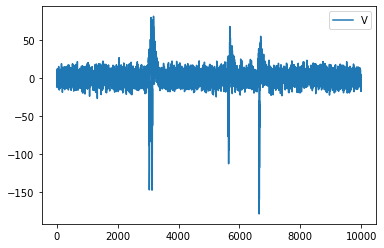

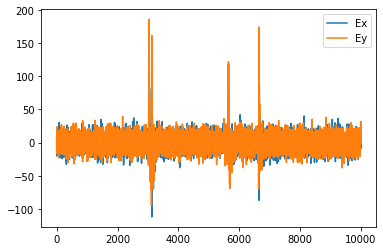

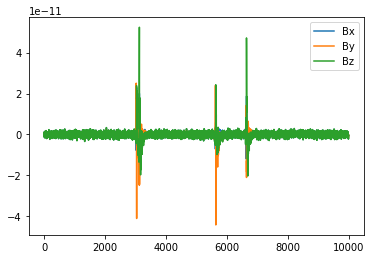

In [30]:
# Get index of electrode with largest spike to plot
elec_plot = np.unravel_index(np.argmax(recgen.mag_recordings[:, 2, :]), np.shape(recgen.mag_recordings[:, 2, :]))[1]

plot_range = slice(0, 10000)
plt.figure()
plt.plot(recgen.recordings[plot_range, elec_plot])
plt.legend('V')

plt.figure()
plt.plot(recgen.mag_recordings[plot_range, 3, elec_plot])
plt.plot(recgen.mag_recordings[plot_range, 4, elec_plot])
plt.legend(['Ex', 'Ey'])

plt.figure()
plt.plot(recgen.mag_recordings[plot_range, 0, elec_plot])
plt.plot(recgen.mag_recordings[plot_range, 1, elec_plot])
plt.plot(recgen.mag_recordings[plot_range, 2, elec_plot])
plt.legend(['Bx', 'By', 'Bz'])

In [ ]:
numcells = 2
template_folder = f'ziad_mearec_templates/mag_templates_6cells_n10.h5'

duration = 20
noise = 5
count = 30
generate_recording_files(numcells, 
                         duration, 
                         noise, 
                         count, 
                         f'Mag_{numcells}Cells_{duration}s_Noise{noise}_Validation', 
                         template_folder)

In [11]:
np.unravel_index(abs(mags[0]).argmax(), mags[0].shape)

(13, 1, 63)

In [21]:
np.unravel_index(eaps[0].argmin(), eaps[0].shape)

(27, 64)

In [18]:
print(eaps.shape[0])
print(mags.shape[0])

10
10


In [30]:
# Templates is # cells x # electrodes x # samples
eaps = tempgen.templates
mags = tempgen.mags
np.shape(eaps)

for i in range(eaps.shape[0]):
    # For AMP feature
    min_idx = np.array([np.unravel_index(eaps[i, e].argmin(), eaps[i, e].shape)[0] for e in range(eaps.shape[1])])
    print(np.unravel_index(abs(mags[i,0]).argmax(), mags[i, 0].shape))
    print(np.unravel_index(abs(mags[i,1]).argmax(), mags[i, 1].shape))
    print(np.unravel_index(abs(mags[i,2]).argmax(), mags[i, 2].shape))
    print()
    min_elid, min_idx_na = np.unravel_index(eaps[i].argmin(), eaps[i].shape)
    
#     print(min_elid)
#     print(min_idx_na)
#     print(max_mid)
#     print(max_idx_mag)
#     print()

(1, 64)
(1, 63)
(1, 63)

(0, 62)
(0, 62)
(0, 62)

(0, 65)
(0, 65)
(0, 64)

(2, 53)
(2, 53)
(2, 53)

(0, 52)
(0, 51)
(0, 51)

(2, 52)
(2, 52)
(0, 52)

(0, 64)
(0, 63)
(0, 63)

(0, 65)
(1, 62)
(1, 62)

(1, 63)
(1, 63)
(1, 63)

(0, 53)
(0, 53)
(0, 53)



In [16]:
template_folder = 'ziad_mearec_templates/mag_templates_6cells_n10.h5'

# Initialize recording parameters

rec_params = mr.get_default_recordings_params()
rec_params['cell_types'] = {'excitatory': ['exc'], 'inhibitory': ['inh']}

rec_params['spiketrains']['duration'] = 20 # number of seconds to generate for
rec_params['spiketrains']['n_exc'] = 6 # number of excitatory cells (randomly selected) to simulate
rec_params['spiketrains']['n_inh'] = 0 # number of inhibitory cells (randomly selected) to simulate
rec_params['templates']['min_dist'] = 30 # minimum distance cells must be from each other in um
rec_params['templates']['min_amp'] = 30 # minimum amplitude? not sure what this is for
rec_params['recordings']['noise_level'] = 1 # noise level added in background - reduced from 10 for initial tests

In [17]:
recgen = mr.gen_recordings(params=rec_params, templates=template_folder, verbose=True, magnetic=True)

Spiketrains seed:  6778
Noise Level  1
Templates selection seed:  2762
Selecting cells
Reordered Idx Cells:  [59, 48, 19, 52, 25, 55]
Voltage Peaks:  (6, 49)
Magnetic Peaks:  (6, 3, 49)
Padding template edges
Non-Padded Templates Size:  (6, 49, 224)
Padded Templates Size:  (6, 49, 416)
Non-Padded Magnetic Templates Size:  (6, 49, 3, 224)
Padded Magnetic Templates Size:  (6, 49, 3, 416)
Elapsed pad time: 0.7425451278686523
Creating time jittering
Template without jitter shape:  (6, 49, 416)
Template with jitter shape:  (6, 10, 49, 416)
Mag Templates with jitter shape:  (6, 10, 49, 3, 416)
Elapsed jitter time: 1.3335530757904053
Computing spike train SNR
Adding spiketrain annotations
Spiketrains shape:  (6,)
Convolution seed:  230
Electrode modulaton
Adding noise
Noise seed:  8689
Magnetic Shape:  (640000, 3, 49)
Peak Electric Electrode:  34
Peak Magnetic Electrode:  19
Peak Elec Power Index:  34
Peak Elec Power:  12.88181953125
Peak Mag Power shape:  (49,)
Peak Mag Power Index, dim 0:  

(640000,)


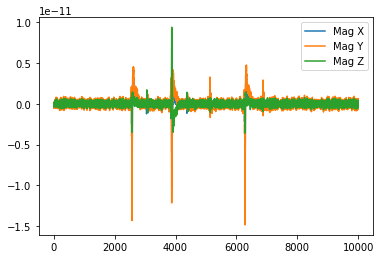

In [22]:
#plt.plot(recgen.mag_recordings[:, 0, 0])
indxs = slice(0,10000)
elec = 39
plt.plot(recgen.mag_recordings[:, 0, elec][indxs])
plt.plot(recgen.mag_recordings[:, 1, elec][indxs])
plt.plot(recgen.mag_recordings[:, 2, elec][indxs])
plt.legend(['Mag X', 'Mag Y', 'Mag Z'])
print(np.shape(recgen.recordings[:, 3]))

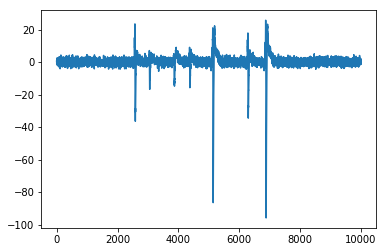

In [21]:
plt.plot(recgen.recordings[:, elec][indxs])

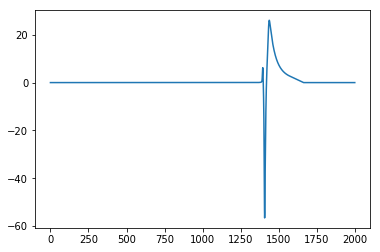

In [20]:
plt.plot(recgen.spike_traces[:, 0][6000:8000])

In [23]:
recgen.mag_scale_factor

[6257372964423.234, 4616674632284.849, 6321021436838.826]

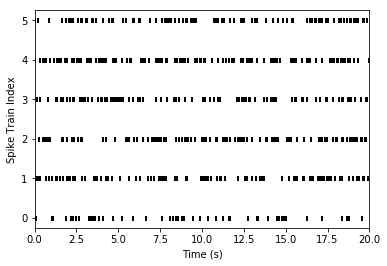

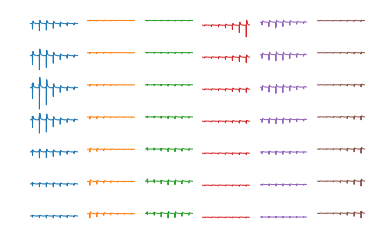

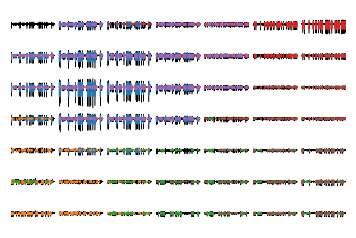

In [4]:
# Plot raster plot, 

ax_st = mr.plot_rasters(recgen.spiketrains)
ax_temp = mr.plot_templates(recgen)
ax_rec = mr.plot_recordings(recgen, start_time=0, end_time=5, overlay_templates=True, lw=0.5)

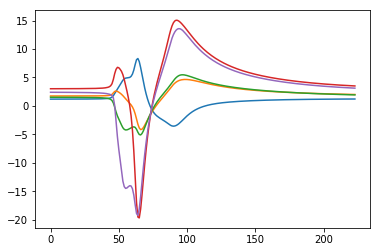

In [8]:
n = 2
elecs = [0, 10, 20, 30, 40]
dim = 0
for elec in elecs:
    #plt.plot(mags[n, elec, dim])
    plt.plot(eaps[n, elec])

In [23]:


for i in range(10):
    for j in range(3):
        print(np.max(mags[i, :, j]))
    print

1.3849856800739846e-11
3.042273585651361e-11
3.4834970671326864e-11
4.43125501853966e-12
7.039526862723187e-12
5.219033906876657e-12
5.57748734704752e-12
9.230125018830178e-12
4.906436277754771e-11
1.5710934333153538e-11
2.009078783572818e-11
9.665448525033458e-12
1.5515168939416964e-11
1.1628013583313327e-11
1.3101269191826344e-11
4.076567306562428e-12
3.3338328802314123e-12
5.894614371820446e-12
3.664697737421571e-12
5.9800809300723295e-12
8.728181217538441e-12
4.000779087243805e-11
8.526757353473437e-12
2.1304618547514822e-11
2.67728216388291e-11
2.683180852984731e-11
1.3736776055497288e-10
1.9038515258722744e-12
2.6799228191692307e-12
3.404412661037316e-12


In [24]:
print(np.)

[[ 38.52103212 -46.15109544   1.8187856 ]
 [ 40.7477393   80.49535821  75.77541504]
 [ 45.61948539 -49.51357648  15.16197907]
 [ 21.99004065 -12.66948754  80.45279282]
 [ 18.86462352 -60.50509076 -83.17642425]
 [ 38.82838699 -71.1477964   37.86059169]
 [ 38.58159306  42.18129009   1.99164754]
 [ 23.45551997  78.28063118  89.57179085]
 [ 29.8735383    3.42888053  64.53606981]
 [ 30.77871495 -78.04064435 -72.0279821 ]]


In [5]:
sim_folder = 'mearec_template_sims'

mr.run_cell_model(cell_models[0], 
                  save=True,
                  sim_folder=sim_folder, 
                  verbose=True,
                  custom_return_cell_function=None, 
                  **template_params)

Setting temperature to 34.000000 C
Setting simulation time step to 0.025000 ms
	1 
	1 
	1 
template bAC217_L5_DBC_4765d943f4 exist already
Input weight: 0.25 - Num Spikes: 11


In [6]:
mea = mu.return_mea(template_params['probe'])
T = template_params['sim_time'] * 1000
dt = template_params['dt']
cell_model_folder = cell_models[0]
cell = mr.return_bbp_cell(cell_model_folder, end_T=T, dt=dt, start_T=0)

Mechanisms already loaded from path: /Users/Ziad/.config/mearec/1.7.2/cell_models/MEArecLinearCells/mods.  Aborting.
template bAC217_L5_DBC_4765d943f4 exist already


In [7]:
cell_name = cell_model_folder.parts[-1]
print(cell_name)

L5_DBC_bAC217_1


In [8]:
load_sim_folder = Path(sim_folder)
imem_file = [f for f in load_sim_folder.iterdir() if cell_name in f.name and 'imem' in f.name][0]
vmem_file = [f for f in load_sim_folder.iterdir() if cell_name in f.name and 'vmem' in f.name][0]
vall_file = [f for f in load_sim_folder.iterdir() if cell_name in f.name and 'vall' in f.name][0]
i_spikes = np.load(str(imem_file))
v_spikes = np.load(str(vmem_file))
vmem_spikes = np.load(str(vall_file))
cell.tvec = np.arange(i_spikes.shape[-1]) * dt

In [21]:
spike_idx = 0
cell.imem = i_spikes[spike_idx, :, :]
cell.vmem = vmem_spikes[spike_idx, :, :]

In [22]:
i_axial, d_vectors, pos_vectors = cell.get_axial_currents_from_vmem()

In [23]:
i_axial

array([[ 0.02105874,  0.02115769,  0.02126043, ..., -0.02038903,
        -0.01961385, -0.01885788],
       [ 0.02105874,  0.02115769,  0.02126043, ..., -0.02038903,
        -0.01961385, -0.01885788],
       [ 0.02001899,  0.02011108,  0.02020667, ..., -0.02023272,
        -0.01947344, -0.01873302],
       ...,
       [-0.01642823, -0.01674475, -0.01707241, ...,  0.00876365,
         0.00864576,  0.00853019],
       [-0.00848781, -0.0086559 , -0.00883007, ...,  0.00433246,
         0.00427457,  0.00421781],
       [-0.00848781, -0.0086559 , -0.00883007, ...,  0.00433246,
         0.00427457,  0.00421781]])

In [7]:
mr.ziad_calculate_magnetic_field(cell, mea, ncontacts=10, position=None, rotation=None)

AttributeError: module 'MEArec' has no attribute 'ziad_calculate_magnetic_field'

In [4]:
dir(mr)

['RecordingGenerator',
 'SpikeTrainGenerator',
 'TemplateGenerator',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'available_probes',
 'calc_extracellular',
 'calculate_extracellular_potential',
 'convert_recording_to_new_version',
 'gen_recordings',
 'gen_spiketrains',
 'gen_templates',
 'generation_tools',
 'generators',
 'get_default_cell_models_folder',
 'get_default_config',
 'get_default_recordings_params',
 'get_default_templates_params',
 'get_templates_features',
 'load_recordings',
 'load_templates',
 'plot_amplitudes',
 'plot_pca_map',
 'plot_rasters',
 'plot_recordings',
 'plot_templates',
 'plot_waveforms',
 'return_bbp_cell',
 'return_bbp_cell_morphology',
 'run_cell_model',
 'save_recording_generator',
 'save_template_generator',
 'simulate_cells',
 'simulate_templates_one_cell',
 'tools',
 'version',
 'ziad_calculate_magnetic_field',
 'ziad_simulate_magnetic_templates']

In [8]:
numcells = 1
tempgen = mr.TemplateGenerator(cell_models_folder = mea_cells_folder,
                               templates_folder = f'ziad_mearec_templates/mag_templates_{numcells}cells_n10.h5')



In [9]:
mr.plot_templates(tempgen, magnetic=True, dim=2)

AttributeError: 'TemplateGenerator' object has no attribute 'templates'

In [5]:
test = np.zeros((1, 20, 5))

In [7]:
np.shape(np.squeeze(test))

(20, 5)

In [45]:
a = 5*np.random.randn(10000, 2)
#print(a)
print(np.sum(a**2)/len(a))

249.12349992832975


In [85]:
print(np.unravel_index(np.argmax(np.sum(recgen.mag_recordings**2, axis=0)/len(recgen.mag_recordings[0])), np.shape(recgen.mag_recordings)))

(0, 0, 35)


In [90]:
len(recgen.recordings)

640000

In [61]:
np.max(a)

20.43125807862849

In [62]:
a[8361, 6]

20.43125807862849

In [64]:
np.shape(recgen.recordings)

(640000, 49)

In [74]:
np.unravel_index(np.argmax(np.abs(recgen.mag_recordings)), np.shape(recgen.mag_recordings))

(105484, 0, 34)

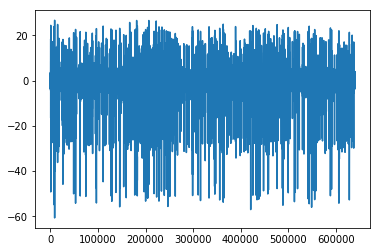

In [73]:
plt.plot(recgen.recordings[:, 30])

In [11]:
mr.__version__

'1.7.2'

In [3]:
mr.ziad_simulate_magnetic_templates

<function MEArec.simulate_cells.ziad_simulate_magnetic_templates(cell_model, intra_save_folder, params, verbose, custom_return_cell_function=None)>

In [4]:
mea

NameError: name 'mea' is not defined

In [14]:
a = np.zeros((64, 2, 10))
b = np.zeros((64, 10))

In [7]:
c = np.concatenate((a, b), axis=1)
np.shape(c)

(64, 20)

In [21]:
c = b.reshape(64, -1)

In [22]:
np.shape(c)

(64, 10)

In [24]:
np.shape(a)[0]

64

In [25]:
a = {'testing':5, 'hello':3}

In [26]:
a.keys()

dict_keys(['testing', 'hello'])

In [27]:
from probeinterface import Probe, ProbeGroup, write_probeinterface, read_probeinterface

ModuleNotFoundError: No module named 'probeinterface'

In [28]:
test = [1, 2, 4, 6, 7]
test2 = [4, 6,5]

In [84]:
cell_model_folder

PosixPath('/Users/Ziad/.config/mearec/1.7.2/cell_models/MEArecLinearCells/L5_TTPC2_cADpyr232_1')

In [98]:
morphologyfile = '/Users/Ziad/.config/mearec/1.7.2/cell_models/MEArecLinearCells/L5_TTPC1_cADpyr232_1/morphology/dend-C060114A2_axon-C060114A5.asc'
def ziad_flatten_geometry2(morphologyfile, cell_folder, max_x):
    new_morph_file = cell_folder / 'morphology/morph_modified.asc'
    with open(morphologyfile, 'rt') as fin:
        with open(new_morph_file, 'wt') as fout:
            for line in fin:
                p1 = line.find('(')
                p2 = line.find(')')
                if p1 > -1 and p2 > -1:
                    if line.count(' ', p1, p2) == 3:
                        space1 = line.find(' ', p1)
                        curr_x = line[p1+1:space1]
                        if float(curr_x) > max_x:
                            print(curr_x, max_x)
                            line = line.replace(curr_x, str(max_x))
                            print(line)
                fout.write(line)

ziad_flatten_geometry2(morphologyfile, cell_model_folder, 20)

21.0346 20
          (20 -146.097 56.3408 0.23)

23.0795 20
          (20 -145.729 57.748 0.23)

23.1037 20
          (20 -145.725 57.7652 0.23)

25.0237 20
          (20 -145.429 59.1307 0.23)

28.2143 20
          (20 -144.96 61.4374 0.23)

30.2881 20
          (20 -144.662 62.9243 0.23)

32.2259 20
          (20 -144.334 64.3503 0.23)

33.7446 20
          (20 -144.056 65.5614 0.23)

35.9121 20
          (20 -143.598 67.4345 0.23)

35.9268 20
          (20 -143.594 67.4476 0.23)

37.9841 20
          (20 -142.909 69.3484 0.23)

39.9255 20
          (20 -142.125 71.146 0.23)

42.9117 20
          (20 -140.827 73.9555 0.23)

44.7583 20
          (20 -139.992 75.7207 0.23)

46.6839 20
          (20 -139.114 77.5632 0.23)

48.862 20
          (20 -138.1 79.6675 0.23)

52.2728 20
          (20 -136.492 82.8537 0.23)

54.3421 20
          (20 -135.516 84.6952 0.23)

54.3634 20
          (20 -135.505 84.7134 0.23)

55.0546 20
          (20 -135.156 85.3189 0.23)

56.023 20
          (20 -1

111.625 20
              (20 -156.498 77.2273 0.23)

111.825 20
              (20 -156.426 77.3015 0.23)

114.242 20
              (20 -155.387 78.4052 0.23)

114.281 20
              (20 -155.366 78.4301 0.23)

116.383 20
              (20 -154.202 79.5375 0.23)

118.451 20
              (20 -153.219 80.2231 0.23)

122.075 20
              (20 -151.598 81.1428 0.23)

125.192 20
              (20 -150.226 81.8066 0.23)

125.219 20
              (20 -150.214 81.8109 0.23)

130.05 20
              (20 -148.248 82.3143 0.23)

135.998 20
              (20 -145.975 82.6045 0.23)

136.017 20
              (20 -145.968 82.6048 0.23)

137.706 20
              (20 -145.296 82.6736 0.23)

142.347 20
              (20 -143.323 83.3862 0.23)

145.219 20
              (20 -142.052 84.145 0.23)

145.244 20
              (20 -142.04 84.1547 0.23)

148.8 20
              (20 -140.369 85.7796 0.23)

151.952 20
              (20 -138.924 87.2598 0.23)

156.512 20
              (20 -136.928 89.5085 0.23)

189.708 20
              (20 -449.838 42.7858 0.23)

189.946 20
              (20 -452.794 42.4284 0.23)

190.075 20
              (20 -455.284 42.0673 0.23)

190.314 20
              (20 -458.254 41.5554 0.23)

190.316 20
              (20 -458.274 41.5517 0.23)

190.902 20
              (20 -461.622 40.8849 0.23)

190.993 20
              (20 -462.003 40.8028 0.23)

191.706 20
              (20 -464.523 40.2247 0.23)

192.931 20
              (20 -468.383 39.2593 0.23)

193.888 20
              (20 -470.975 38.6501 0.23)

195.014 20
              (20 -473.732 37.9975 0.23)

196.305 20
              (20 -476.622 37.3166 0.23)

196.317 20
              (20 -476.648 37.3102 0.23)

197.842 20
              (20 -479.655 36.5138 0.23)

199.137 20
              (20 -482.196 35.7403 0.23)

200.272 20
              (20 -484.442 35.0062 0.23)

200.367 20
              (20 -484.639 34.934 0.23)

201.525 20
              (20 -487.574 33.809 0.23)

202.459 20
              (20 -490.429 32.5644 0.

234.743 20
                (20 -146.005 -89.6007 0.46)

234.757 20
                (20 -146.008 -89.6147 0.46)

236.635 20
                (20 -146.46 -91.5424 0.46)

239.601 20
                (20 -147.312 -94.4736 0.46)

241.987 20
                (20 -148.1 -96.719 0.46)

242.01 20
                (20 -148.108 -96.7374 0.46)

246.526 20
                (20 -149.807 -99.9856 0.46)

246.55 20
                (20 -149.816 -100.001 0.46)

250.255 20
                (20 -151.082 -101.996 0.46)

250.298 20
                (20 -151.096 -102.016 0.46)

254.182 20
                (20 -152.165 -103.684 0.46)

254.227 20
                (20 -152.178 -103.701 0.46)

257.671 20
                (20 -153.243 -104.785 0.46)

262.531 20
                (20 -154.759 -106.224 0.46)

262.559 20
                (20 -154.768 -106.232 0.46)

267.531 20
                (20 -156.507 -107.447 0.46)

273.785 20
                (20 -158.834 -109.025 0.46)

277.114 20
                (20 -160.136 -109.929 0.46)

174.341 20
                  (20 -176.562 169.43 0.46)

175.774 20
                  (20 -176.371 171.914 0.46)

175.797 20
                  (20 -176.368 171.957 0.46)

176.945 20
                  (20 -176.319 174.042 0.46)

178.331 20
                  (20 -176.417 176.416 0.46)

178.347 20
                  (20 -176.419 176.442 0.46)

179.592 20
                  (20 -176.68 178.347 0.46)

181.217 20
                  (20 -177.049 180.672 0.46)

182.857 20
                  (20 -177.353 183.046 0.46)

182.869 20
                  (20 -177.355 183.063 0.46)

185.149 20
                  (20 -177.541 186.618 0.46)

185.164 20
                  (20 -177.541 186.644 0.46)

187.482 20
                  (20 -177.42 190.86 0.46)

188.733 20
                  (20 -177.311 193.309 0.46)

190.172 20
                  (20 -177.187 196.232 0.46)

191.426 20
                  (20 -177.095 198.747 0.46)

193.12 20
                  (20 -176.963 202.048 0.46)

195.349 20
                  (20 -17

218.263 20
                (20 -183.856 -3.29747 0.46)

220.042 20
                (20 -182.181 -2.86852 0.46)

222.922 20
                (20 -179.43 -2.20667 0.46)

223.017 20
                (20 -179.341 -2.19829 0.46)

224.785 20
                (20 -177.577 -2.3977 0.46)

224.799 20
                (20 -177.564 -2.40191 0.46)

226.462 20
                (20 -176.01 -3.22659 0.46)

228.039 20
                (20 -174.524 -4.15729 0.46)

230.035 20
                (20 -172.599 -5.39204 0.46)

231.997 20
                (20 -170.789 -6.45354 0.46)

233.606 20
                (20 -169.358 -7.20482 0.46)

234.967 20
                (20 -168.135 -7.81161 0.46)

236.727 20
                (20 -166.521 -8.52709 0.46)

238.596 20
                (20 -164.875 -9.23135 0.46)

241.71 20
                (20 -162.325 -10.2947 0.46)

243.745 20
                (20 -160.795 -10.9066 0.46)

243.745 20
                  (20 -160.795 -10.9066 0.46)

243.954 20
                  (20 -157.73 -13.6084 

85.8288 20
        (20 -151.576 -44.8035 0.59)

85.5072 20
        (20 -152.357 -45.2578 0.59)

85.3232 20
        (20 -152.852 -45.5552 1.11)

85.2001 20
        (20 -153.241 -45.7881 1.11)

85.0471 20
        (20 -153.728 -46.0282 1.11)

84.479 20
        (20 -155.372 -46.6105 0.37)

83.7917 20
        (20 -157.177 -47.16 0.37)

83.5854 20
        (20 -157.661 -47.2888 0.37)

83.3698 20
        (20 -158.134 -47.3961 0.37)

82.5712 20
        (20 -159.638 -47.5864 0.15)

82.2548 20
        (20 -160.108 -47.5339 0.15)

82.0207 20
        (20 -160.333 -47.4016 0.15)

81.794 20
        (20 -160.41 -47.2723 0.15)

71.4292 20
        (20 -48.5253 -10.7749 1.77)

72.4061 20
        (20 -48.6601 -12.5412 1.03)

72.6999 20
        (20 -48.7484 -13.1606 1.03)

73.4693 20
        (20 -49.0756 -14.9196 0.88)

73.675 20
        (20 -49.1978 -15.47 0.88)

74.1994 20
        (20 -49.647 -16.9723 0.88)

74.8438 20
        (20 -50.3015 -18.8597 0.88)

75.0034 20
        (20 -50.5193 -19.4742 0.88)

7

35.0664 20
            (20 4.97155 -23.5345 0.07)

36.2865 20
            (20 5.09853 -23.6248 0.37)

36.8902 20
            (20 5.2281 -23.6938 0.37)

37.3408 20
            (20 5.36383 -23.675 0.37)

37.922 20
            (20 5.63465 -23.6137 1.33)

38.1517 20
            (20 5.77309 -23.5809 1.33)

38.9846 20
            (20 6.39857 -23.438 1.33)

40.5282 20
            (20 7.80847 -23.1422 1.33)

42.3149 20
            (20 9.61104 -22.8548 0.88)

44.1142 20
            (20 11.5611 -22.6232 0.74)

44.833 20
            (20 12.3997 -22.5115 0.74)

45.1811 20
            (20 12.8296 -22.4501 0.74)

46.0545 20
            (20 13.9259 -22.2816 0.74)

46.8848 20
            (20 14.9823 -22.1647 0.22)

47.5664 20
            (20 15.7385 -22.1439 0.74)

49.1247 20
            (20 16.9912 -22.0383 0.74)

50.0135 20
            (20 17.5752 -21.9643 0.74)

51.1953 20
            (20 18.2593 -21.8497 0.74)

51.4484 20
            (20 18.3918 -21.8309 0.74)

52.2603 20
            (20 18.8274 -


115.476 20
                                        (20 951.855 -77.929 0.46)

116.303 20
                                        (20 954.11 -77.7885 0.46)

117.28 20
                                        (20 956.835 -77.3691 0.46)

118.576 20
                                        (20 960.813 -76.4552 0.46)

119.09 20
                                        (20 962.618 -75.9474 0.46)

119.837 20
                                        (20 965.639 -74.9127 0.46)

120.309 20
                                        (20 967.897 -73.9164 0.46)

120.318 20
                                        (20 967.941 -73.8934 0.46)

120.93 20
                                        (20 970.44 -72.3895 0.46)

120.942 20
                                        (20 970.481 -72.3634 0.46)

121.542 20
                                        (20 972.503 -71.031 0.46)

122.275 20
                                        (20 975.123 -69.2646 0.46)

123.04 20
                                        (20 977.

In [99]:
a = {'hi': 5, 'hey': 6}

In [103]:
'hu' in a.keys()

False

In [3]:
mea = mu.return_mea('100MEA75')

In [21]:
mea2 = mu.return_mea(info=mea_info)

In [15]:
pos = np.vstack((mea2.positions, mea2.positions + np.array([-2, 0, 0])))
mea_info = {'pos': pos, 'center':False}

In [22]:
mea2.positions

array([[   0. , -337.5, -337.5],
       [   0. , -337.5, -262.5],
       [   0. , -337.5, -187.5],
       [   0. , -337.5, -112.5],
       [   0. , -337.5,  -37.5],
       [   0. , -337.5,   37.5],
       [   0. , -337.5,  112.5],
       [   0. , -337.5,  187.5],
       [   0. , -337.5,  262.5],
       [   0. , -337.5,  337.5],
       [   0. , -262.5, -337.5],
       [   0. , -262.5, -262.5],
       [   0. , -262.5, -187.5],
       [   0. , -262.5, -112.5],
       [   0. , -262.5,  -37.5],
       [   0. , -262.5,   37.5],
       [   0. , -262.5,  112.5],
       [   0. , -262.5,  187.5],
       [   0. , -262.5,  262.5],
       [   0. , -262.5,  337.5],
       [   0. , -187.5, -337.5],
       [   0. , -187.5, -262.5],
       [   0. , -187.5, -187.5],
       [   0. , -187.5, -112.5],
       [   0. , -187.5,  -37.5],
       [   0. , -187.5,   37.5],
       [   0. , -187.5,  112.5],
       [   0. , -187.5,  187.5],
       [   0. , -187.5,  262.5],
       [   0. , -187.5,  337.5],
       [  

In [82]:
mea.positions

AttributeError: 'NoneType' object has no attribute 'positions'

In [18]:
a = np.linspace(0, 10, 10)

In [19]:
a

array([ 0.        ,  1.11111111,  2.22222222,  3.33333333,  4.44444444,
        5.55555556,  6.66666667,  7.77777778,  8.88888889, 10.        ])